In [1]:
#Trying to replicate the results of "Adaptive activation functions accelerate convergence in deep and physics-informed neural networks"
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:1


In [2]:
def true_smooth(x): #[-3,3]
    term1 = (np.power(x,3) - x)
    term2 = np.sin(7*x)/7  

    
    term3 = np.sin(12*x)*np.exp(abs(x))
    term12 = np.multiply(term1,term2)

    return 50*(term12  + term3)

In [3]:
# Domain bounds
label = "Regr_smooth_Stan"
loss_thresh = 0.1

lb = np.array(-3.0)  # [-1. 0.]
ub = np.array(3.0) # [1.  0.99]

x_test = np.linspace(lb,ub,1000).reshape(-1,1)
u_true = true_smooth(x_test)

u_true_norm = np.linalg.norm(u_true,2)

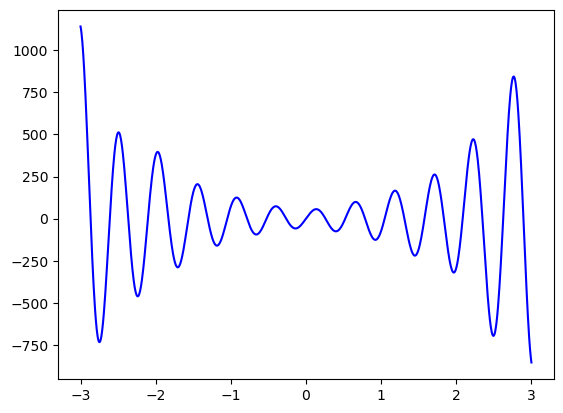

In [4]:
plt.plot(x_test,u_true,'b')

In [5]:
def trainingdata(N_train,seed):
    np.random.seed(seed)
    
    x_train = np.random.uniform(low=lb, high=ub, size=(N_train,)).reshape(-1,1)

    u_train = true_smooth(x_train)

    return x_train, u_train

In [6]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers,beta_init):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        
        self.beta = Parameter(beta_init*torch.ones((layers[1],len(layers)-2)))
        self.beta.requiresGrad = True
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z) + self.beta[:,i]*z*self.activation(z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse_loss, test_re_loss  

In [7]:
def data_update(loss_np):
    train_loss.append(loss_np)
    beta_val.append(model_NN.beta.cpu().detach().numpy())
    test_mse, test_re = model_NN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [8]:
def train_step():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = model_NN.loss(x_train,u_train)
    loss.backward() #backprop
    optimizer.step()
    
    return loss

In [9]:
def train_model(max_iter,rep):
    print(rep) 
   
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    for i in range(max_iter):
        loss_np = train_step().cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1
                
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [10]:
max_reps = 5
max_iter = 3000
layers = np.array([1,50,50,50,50,1])

train_loss_full = []
test_mse_full = []
test_re_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))

beta_init = 1


for reps in range(max_reps):
    
    train_loss = []
    test_mse_loss = []
    test_re_loss = []
    beta_val = []
    'Generate Training data'
    N_train = 300
    
    x_train_np_array, u_train_np_array = trainingdata(N_train,reps*1234)

    'Convert to tensor and send to GPU'
    x_train = torch.from_numpy(x_train_np_array).float().to(device)
    u_train = torch.from_numpy(u_train_np_array).float().to(device)
    
    x_test_tensor = torch.from_numpy(x_test).float().to(device)
       
     
    model_NN = Sequentialmodel(layers,beta_init)
    model_NN.to(device)
    print(model_NN)
    params = list(model_NN.parameters())
    #optimizer = optim.Adam(PINN.parameters(), lr=0.0008,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    optimizer = optim.Adam(model_NN.parameters(), lr=0.008)

    train_model(max_iter,reps)
 
    torch.save(model_NN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    beta_full.append(beta_val)
                 

mdic = {"train_loss": train_loss_full,"test_mse": test_mse_full, "test_re": test_re_full,"Time": elapsed_time, "Thresh_time": time_threshold, "epoch_thresh": epoch_threshold,"beta": beta_full, "label": label}
savemat(label+'.mat', mdic) 

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 73256.375 Test MSE 85799.75658399575 Test RE 0.9999340597638693
1 Train Loss 73139.09 Test MSE 85792.18958275761 Test RE 0.9998899648304655
2 Train Loss 73003.04 Test MSE 85791.45490989559 Test RE 0.9998856835922879
3 Train Loss 72843.91 Test MSE 85805.52468175745 Test RE 0.9999676707011701
4 Train Loss 72649.8 Test MSE 85848.94419574752 Test RE 1.0002206417026545
5 Train Loss 72420.84 Test MSE 85943.7113983503 Test RE 1.0007725527876756
6 Train Loss 72170.19 Test MSE 86119.7136550893 Test RE 1.0017967588623014
7 Train Loss 71917.53 Test MSE 86415.64310625258 Test RE 1.00351649822

110 Train Loss 62521.023 Test MSE 85581.49853292409 Test RE 0.9986614301140516
111 Train Loss 60392.895 Test MSE 83598.51629590333 Test RE 0.9870237855454409
112 Train Loss 59505.508 Test MSE 83165.00618416794 Test RE 0.9844612942152638
113 Train Loss 61166.402 Test MSE 86980.58402667282 Test RE 1.006791391287003
114 Train Loss 63267.336 Test MSE 84495.30710969043 Test RE 0.9923037397313436
115 Train Loss 58883.293 Test MSE 85855.0423842999 Test RE 1.0002561658771778
116 Train Loss 61579.066 Test MSE 86292.84137234077 Test RE 1.0028032166147132
117 Train Loss 61937.543 Test MSE 82429.74859917983 Test RE 0.980099846893671
118 Train Loss 58218.754 Test MSE 84462.6376073242 Test RE 0.9921118876354023
119 Train Loss 61947.99 Test MSE 83176.13615155208 Test RE 0.9845271672069728
120 Train Loss 60355.027 Test MSE 82533.17995085566 Test RE 0.9807145598664327
121 Train Loss 57654.45 Test MSE 86191.5668189663 Test RE 1.002214591524894
122 Train Loss 60835.293 Test MSE 82529.5838085258 Test RE 0

223 Train Loss 40473.832 Test MSE 48427.84357273206 Test RE 0.7512351482017265
224 Train Loss 32466.217 Test MSE 52780.44129598097 Test RE 0.7842686267917153
225 Train Loss 36951.727 Test MSE 62295.218889818534 Test RE 0.8520315797600997
226 Train Loss 46173.62 Test MSE 70953.24252149128 Test RE 0.9093152137479404
227 Train Loss 47277.855 Test MSE 51134.11687399869 Test RE 0.7719402986268192
228 Train Loss 34203.637 Test MSE 56981.074135379895 Test RE 0.8148799826367176
229 Train Loss 46050.28 Test MSE 81865.84569181729 Test RE 0.9767416562269037
230 Train Loss 59702.47 Test MSE 61276.64923722294 Test RE 0.8450372202575287
231 Train Loss 38764.555 Test MSE 78019.95194176752 Test RE 0.9535229995051451
232 Train Loss 66729.51 Test MSE 67650.30740173584 Test RE 0.8878982926596636
233 Train Loss 52079.984 Test MSE 70298.322137966 Test RE 0.9051088543496772
234 Train Loss 47239.395 Test MSE 73224.78231455278 Test RE 0.923756225645715
235 Train Loss 54789.15 Test MSE 47884.59054759139 Test R

337 Train Loss 23484.543 Test MSE 31298.59150621956 Test RE 0.6039357391875821
338 Train Loss 21831.93 Test MSE 26616.16511131701 Test RE 0.556930592648381
339 Train Loss 18080.668 Test MSE 24484.133368051607 Test RE 0.5341591866608826
340 Train Loss 15644.477 Test MSE 25985.52856504847 Test RE 0.5502931556732455
341 Train Loss 16397.203 Test MSE 26156.189451155347 Test RE 0.5520972334026751
342 Train Loss 18234.21 Test MSE 28061.111831661874 Test RE 0.5718482165374401
343 Train Loss 18379.22 Test MSE 24778.22048632337 Test RE 0.537357593405925
344 Train Loss 16698.617 Test MSE 24745.167831323066 Test RE 0.5369990724587033
345 Train Loss 15726.127 Test MSE 25598.60014393023 Test RE 0.54618081607337
346 Train Loss 17165.639 Test MSE 29171.294931276287 Test RE 0.583050521014333
347 Train Loss 20639.443 Test MSE 32973.38668500045 Test RE 0.6198835500134555
348 Train Loss 25231.457 Test MSE 39664.54978922233 Test RE 0.6798758241942789
349 Train Loss 31534.078 Test MSE 39688.97042410213 Tes

441 Train Loss 14684.667 Test MSE 22611.584336737724 Test RE 0.5133266719566528
442 Train Loss 17407.729 Test MSE 23049.16409972748 Test RE 0.5182698247812387
443 Train Loss 18671.248 Test MSE 25501.68567813787 Test RE 0.5451459349324462
444 Train Loss 20593.305 Test MSE 23735.426373579634 Test RE 0.5259286776458006
445 Train Loss 19188.723 Test MSE 22383.148055789316 Test RE 0.5107271171412948
446 Train Loss 17623.424 Test MSE 19426.209628695553 Test RE 0.4757977337687816
447 Train Loss 14425.932 Test MSE 16501.10773151511 Test RE 0.43851543414342364
448 Train Loss 11573.402 Test MSE 14910.860103012865 Test RE 0.4168498806534781
449 Train Loss 9721.992 Test MSE 14477.434587187821 Test RE 0.4107467533839452
450 Train Loss 9387.096 Test MSE 15368.58848445126 Test RE 0.42319967417013166
451 Train Loss 10318.693 Test MSE 16738.08480553078 Test RE 0.4416530313927333
452 Train Loss 11783.787 Test MSE 18110.952733942842 Test RE 0.4594084534606233
453 Train Loss 13215.582 Test MSE 18617.39261

545 Train Loss 7266.494 Test MSE 10673.611387059285 Test RE 0.3526825945085039
546 Train Loss 7848.437 Test MSE 12033.670338975977 Test RE 0.3744789312307742
547 Train Loss 8938.797 Test MSE 12158.494421742615 Test RE 0.3764161372008572
548 Train Loss 9624.88 Test MSE 13211.079293948622 Test RE 0.39237152579758955
549 Train Loss 10110.583 Test MSE 12033.174998818264 Test RE 0.37447122384156784
550 Train Loss 9435.963 Test MSE 11700.993294383263 Test RE 0.36926632047275515
551 Train Loss 8796.799 Test MSE 10766.902246656486 Test RE 0.3542205220194898
552 Train Loss 8017.632 Test MSE 10255.087011674888 Test RE 0.34569890864554814
553 Train Loss 7455.96 Test MSE 9842.652773276923 Test RE 0.33867599540925863
554 Train Loss 7061.6436 Test MSE 9621.490743126524 Test RE 0.33484939367645855
555 Train Loss 6849.2637 Test MSE 9508.338502139293 Test RE 0.33287459490632737
556 Train Loss 6786.5454 Test MSE 9581.733439991478 Test RE 0.3341568559933171
557 Train Loss 6819.091 Test MSE 9536.576070098

659 Train Loss 37171.96 Test MSE 31684.4318365449 Test RE 0.6076469125469709
660 Train Loss 30874.867 Test MSE 21766.651020661087 Test RE 0.5036445524757771
661 Train Loss 20925.75 Test MSE 13075.84203011117 Test RE 0.39035807377519793
662 Train Loss 11895.014 Test MSE 10888.079403122052 Test RE 0.3562082496876039
663 Train Loss 9843.484 Test MSE 14917.013963842677 Test RE 0.4169358908337997
664 Train Loss 13426.342 Test MSE 15133.663102017948 Test RE 0.4199526871743531
665 Train Loss 14070.07 Test MSE 13974.69333084078 Test RE 0.40355197473719295
666 Train Loss 12675.392 Test MSE 11848.706281082485 Test RE 0.3715898139927229
667 Train Loss 10416.386 Test MSE 10186.709828300038 Test RE 0.3445444839289501
668 Train Loss 9636.099 Test MSE 13746.691584728715 Test RE 0.4002463943756562
669 Train Loss 11966.17 Test MSE 11708.743839964201 Test RE 0.3693885981971859
670 Train Loss 10764.846 Test MSE 10928.32520431539 Test RE 0.356865971899175
671 Train Loss 9824.76 Test MSE 10539.070408957332

770 Train Loss 5749.2344 Test MSE 6453.043727928413 Test RE 0.2742272684504265
771 Train Loss 5815.957 Test MSE 6167.68207404205 Test RE 0.26809537581125487
772 Train Loss 5296.08 Test MSE 5646.892725404248 Test RE 0.25652701192615557
773 Train Loss 4797.5312 Test MSE 5572.353090123175 Test RE 0.25482829441444493
774 Train Loss 4888.9785 Test MSE 6617.767087216507 Test RE 0.277705238872728
775 Train Loss 5697.193 Test MSE 7010.078585847247 Test RE 0.2858181323269024
776 Train Loss 6644.0366 Test MSE 8307.072183372939 Test RE 0.3111374770747353
777 Train Loss 7501.0303 Test MSE 7956.744210555531 Test RE 0.3045061245890219
778 Train Loss 7740.9077 Test MSE 9075.459467312976 Test RE 0.32520906624694496
779 Train Loss 8229.889 Test MSE 8166.408068383278 Test RE 0.3084919760601646
780 Train Loss 7879.115 Test MSE 8950.302853704989 Test RE 0.32295885683631365
781 Train Loss 8111.4487 Test MSE 7763.944210682302 Test RE 0.3007942546483279
782 Train Loss 7176.12 Test MSE 7145.598015304643 Test 

879 Train Loss 13130.357 Test MSE 11667.083643271699 Test RE 0.36873086262910987
880 Train Loss 11334.36 Test MSE 7902.269210623096 Test RE 0.3034619499725457
881 Train Loss 7480.8125 Test MSE 5373.4902553348675 Test RE 0.2502399050072469
882 Train Loss 4814.06 Test MSE 5109.434732042849 Test RE 0.24401400981201246
883 Train Loss 4354.528 Test MSE 5333.63820130875 Test RE 0.24931023613089767
884 Train Loss 5231.2583 Test MSE 6865.277335168248 Test RE 0.28285077740269204
885 Train Loss 6057.204 Test MSE 5655.165085085296 Test RE 0.2567148415167875
886 Train Loss 5501.559 Test MSE 5125.2249031986685 Test RE 0.2443907687815988
887 Train Loss 4438.179 Test MSE 4388.973266293231 Test RE 0.22615687861967526
888 Train Loss 3756.071 Test MSE 4270.821515463572 Test RE 0.22309202453049934
889 Train Loss 4106.1387 Test MSE 5518.526472454505 Test RE 0.2535945400255933
890 Train Loss 4974.3623 Test MSE 5364.508710856416 Test RE 0.25003068523745736
891 Train Loss 5518.0874 Test MSE 5977.278010508226

983 Train Loss 3648.369 Test MSE 3112.5491810192775 Test RE 0.19045239783940907
984 Train Loss 2652.5059 Test MSE 2777.929667427104 Test RE 0.17992394161168768
985 Train Loss 2410.3406 Test MSE 3254.426766961399 Test RE 0.1947446722834623
986 Train Loss 2810.3308 Test MSE 3766.77986655157 Test RE 0.2095141956364453
987 Train Loss 3476.3325 Test MSE 4335.933322738195 Test RE 0.2247861925396021
988 Train Loss 4028.8735 Test MSE 4687.613392034156 Test RE 0.23372449326371297
989 Train Loss 4412.6304 Test MSE 4790.319777904893 Test RE 0.23627109093116525
990 Train Loss 4670.267 Test MSE 5565.147730514216 Test RE 0.2546634876076702
991 Train Loss 5351.196 Test MSE 5709.551479896308 Test RE 0.2579463163637151
992 Train Loss 5769.062 Test MSE 6665.159273886989 Test RE 0.27869783800662906
993 Train Loss 6501.0576 Test MSE 5953.516244881786 Test RE 0.2633995964167677
994 Train Loss 6156.927 Test MSE 6197.719024224484 Test RE 0.26874740252059487
995 Train Loss 5835.454 Test MSE 4504.274712418062 

1088 Train Loss 2810.6838 Test MSE 3378.4132619142906 Test RE 0.19841966877361022
1089 Train Loss 3316.0112 Test MSE 4055.839271054075 Test RE 0.21740458635655094
1090 Train Loss 3546.2568 Test MSE 3492.2602857303905 Test RE 0.2017351782032935
1091 Train Loss 3344.1587 Test MSE 3479.024902174731 Test RE 0.2013525353218998
1092 Train Loss 3011.5894 Test MSE 2948.0537393533045 Test RE 0.18535146869385172
1093 Train Loss 2616.2893 Test MSE 2670.269193129705 Test RE 0.17640295518795474
1094 Train Loss 2424.9233 Test MSE 2880.578425535653 Test RE 0.18321802001424217
1095 Train Loss 2474.4482 Test MSE 2793.7991447638406 Test RE 0.18043713542782666
1096 Train Loss 2666.7988 Test MSE 3233.7017117330265 Test RE 0.1941235889636772
1097 Train Loss 2899.376 Test MSE 3201.452304345889 Test RE 0.19315317516127598
1098 Train Loss 3143.5544 Test MSE 3612.434273687767 Test RE 0.20517682768414197
1099 Train Loss 3367.0647 Test MSE 3579.7889913274716 Test RE 0.20424764030270862
1100 Train Loss 3571.745 T

1199 Train Loss 8591.739 Test MSE 8157.895103262477 Test RE 0.30833114242472065
1200 Train Loss 8408.055 Test MSE 8006.810839823154 Test RE 0.3054626519917453
1201 Train Loss 7785.132 Test MSE 6643.656559666673 Test RE 0.2782479161896194
1202 Train Loss 6347.542 Test MSE 5790.076131249691 Test RE 0.25975892048218596
1203 Train Loss 5606.8184 Test MSE 6481.9242863604295 Test RE 0.27484023463060314
1204 Train Loss 5963.516 Test MSE 6191.153320043457 Test RE 0.26860501275543497
1205 Train Loss 6578.166 Test MSE 6844.661260916993 Test RE 0.28242576493179344
1206 Train Loss 6452.4683 Test MSE 4960.773159786369 Test RE 0.2404379508475811
1207 Train Loss 5475.3535 Test MSE 4351.056881249619 Test RE 0.2251778738286508
1208 Train Loss 3792.0476 Test MSE 2520.583850057586 Test RE 0.17138740706717348
1209 Train Loss 2424.1318 Test MSE 2262.4270469539374 Test RE 0.16237367708109607
1210 Train Loss 1902.7479 Test MSE 2769.9740016931005 Test RE 0.17966611631915622
1211 Train Loss 2400.3782 Test MSE 

1301 Train Loss 3145.904 Test MSE 3084.6177893749236 Test RE 0.18959593127286498
1302 Train Loss 3089.8367 Test MSE 3322.2322670745934 Test RE 0.19676295205235866
1303 Train Loss 3023.676 Test MSE 3105.5317452410122 Test RE 0.19023758330286694
1304 Train Loss 3055.176 Test MSE 3520.092441597055 Test RE 0.2025374641081766
1305 Train Loss 3207.3528 Test MSE 3446.458080901249 Test RE 0.20040789849238144
1306 Train Loss 3446.5305 Test MSE 4209.811086138477 Test RE 0.22149281230164522
1307 Train Loss 3969.021 Test MSE 4420.37757145783 Test RE 0.22696454361638582
1308 Train Loss 4587.9478 Test MSE 5996.018273442415 Test RE 0.2643381264773334
1309 Train Loss 5813.399 Test MSE 6398.659063776523 Test RE 0.2730692634834816
1310 Train Loss 6767.295 Test MSE 8745.079330578488 Test RE 0.3192347871118731
1311 Train Loss 8546.828 Test MSE 8646.22344708553 Test RE 0.3174253164179594
1312 Train Loss 8998.282 Test MSE 9975.72477757625 Test RE 0.3409577473720185
1313 Train Loss 9727.458 Test MSE 9690.680

1404 Train Loss 2861.7952 Test MSE 2194.052165778207 Test RE 0.1599012314044979
1405 Train Loss 2018.7493 Test MSE 2342.7988153853353 Test RE 0.16523263609525987
1406 Train Loss 2253.725 Test MSE 2905.233079955887 Test RE 0.184000424083826
1407 Train Loss 2730.0334 Test MSE 2783.5262133137826 Test RE 0.18010509197593796
1408 Train Loss 2792.9202 Test MSE 2839.0694840045207 Test RE 0.1818931501960756
1409 Train Loss 2570.1055 Test MSE 2718.441322315623 Test RE 0.1779870132267012
1410 Train Loss 2602.7817 Test MSE 3059.7056053902907 Test RE 0.18882876588956213
1411 Train Loss 2851.4788 Test MSE 3099.3328719211704 Test RE 0.19004762424971489
1412 Train Loss 3035.1836 Test MSE 3527.8316905021693 Test RE 0.20275999054070507
1413 Train Loss 3321.8848 Test MSE 3862.2230650899432 Test RE 0.21215194135835128
1414 Train Loss 3809.2075 Test MSE 5551.215029045794 Test RE 0.2543445047109918
1415 Train Loss 5310.1885 Test MSE 6500.427679226979 Test RE 0.2752322364895191
1416 Train Loss 6553.0195 Tes

1512 Train Loss 3182.92 Test MSE 3579.148819003957 Test RE 0.20422937672167593
1513 Train Loss 3576.0017 Test MSE 4348.327964790841 Test RE 0.22510724869055423
1514 Train Loss 3865.235 Test MSE 3616.728456777502 Test RE 0.20529874065425438
1515 Train Loss 3599.1138 Test MSE 3656.309695734814 Test RE 0.20641907176209667
1516 Train Loss 3168.5974 Test MSE 3133.125692136961 Test RE 0.19108088437490944
1517 Train Loss 2842.4983 Test MSE 3006.5155218274417 Test RE 0.18718026546378963
1518 Train Loss 2810.6917 Test MSE 3447.7404687269477 Test RE 0.2004451797737522
1519 Train Loss 3114.9187 Test MSE 3430.2330248346734 Test RE 0.1999356070397497
1520 Train Loss 3541.4055 Test MSE 3961.713758443062 Test RE 0.21486707933750807
1521 Train Loss 3704.1692 Test MSE 3396.631515172664 Test RE 0.19895394318994483
1522 Train Loss 3475.5522 Test MSE 3622.8105891087016 Test RE 0.20547129018470528
1523 Train Loss 3376.6716 Test MSE 3524.58543685661 Test RE 0.20266668083880293
1524 Train Loss 3538.7869 Test

1617 Train Loss 2972.6448 Test MSE 3405.0370502645233 Test RE 0.19919996355102645
1618 Train Loss 2978.7688 Test MSE 3216.365516153645 Test RE 0.1936025317589951
1619 Train Loss 3087.8115 Test MSE 3576.1961321181475 Test RE 0.20414511788619724
1620 Train Loss 3234.5005 Test MSE 3219.019207796972 Test RE 0.1936823820575519
1621 Train Loss 3264.026 Test MSE 3227.0460221846292 Test RE 0.19392371093486227
1622 Train Loss 2935.528 Test MSE 2545.7578556570866 Test RE 0.17224113553174042
1623 Train Loss 2485.0251 Test MSE 2416.014950024224 Test RE 0.1677946626673592
1624 Train Loss 2043.9384 Test MSE 1974.9658085249416 Test RE 0.1517078747257397
1625 Train Loss 1769.9475 Test MSE 1918.604609223042 Test RE 0.14952750109542642
1626 Train Loss 1665.8853 Test MSE 1969.9735646575352 Test RE 0.1515160126899445
1627 Train Loss 1707.0156 Test MSE 1991.372581617853 Test RE 0.15233671819474626
1628 Train Loss 1816.6108 Test MSE 2207.854852020696 Test RE 0.16040340867656394
1629 Train Loss 1935.9778 Tes

1729 Train Loss 3098.2605 Test MSE 3164.611976771037 Test RE 0.19203861599656455
1730 Train Loss 2946.7356 Test MSE 2809.055166929735 Test RE 0.18092911875416207
1731 Train Loss 2706.3176 Test MSE 2689.828767935073 Test RE 0.17704784735945295
1732 Train Loss 2384.275 Test MSE 2311.6368899321715 Test RE 0.16413006517034573
1733 Train Loss 2097.9697 Test MSE 2330.033817919639 Test RE 0.1647818771429417
1734 Train Loss 1963.654 Test MSE 2269.9186505683724 Test RE 0.16264228991633922
1735 Train Loss 1983.5413 Test MSE 2367.169813582129 Test RE 0.1660898300501677
1736 Train Loss 2087.3022 Test MSE 2578.614277282552 Test RE 0.17334907363934463
1737 Train Loss 2224.4702 Test MSE 2546.9356045345585 Test RE 0.17228097304947473
1738 Train Loss 2385.4883 Test MSE 2926.6083244184256 Test RE 0.18467607489582413
1739 Train Loss 2592.6646 Test MSE 2883.0681421828504 Test RE 0.18329718162059744
1740 Train Loss 2865.6362 Test MSE 3322.4492786609353 Test RE 0.19676937832536567
1741 Train Loss 3083.9685 

1834 Train Loss 2191.562 Test MSE 2143.766318747581 Test RE 0.15805820857893088
1835 Train Loss 1967.9808 Test MSE 2082.9766428595954 Test RE 0.1558011050770646
1836 Train Loss 1827.3115 Test MSE 2084.0372136695514 Test RE 0.15584076396544358
1837 Train Loss 1876.4261 Test MSE 2235.703725232261 Test RE 0.16141186627204526
1838 Train Loss 1990.7677 Test MSE 2225.1653760328213 Test RE 0.16103099651899358
1839 Train Loss 2060.6829 Test MSE 2506.688658517054 Test RE 0.17091435159055593
1840 Train Loss 2252.192 Test MSE 2806.125684325234 Test RE 0.18083475126499798
1841 Train Loss 2667.481 Test MSE 3577.2098972201507 Test RE 0.20417405093740482
1842 Train Loss 3390.352 Test MSE 4076.520832820926 Test RE 0.21795817697009848
1843 Train Loss 4052.81 Test MSE 5158.765619785615 Test RE 0.24518914100061215
1844 Train Loss 5003.9976 Test MSE 5336.969790391395 Test RE 0.24938808820524402
1845 Train Loss 5442.7075 Test MSE 6197.2952150819665 Test RE 0.268738213692176
1846 Train Loss 6061.9883 Test M

1940 Train Loss 3844.9917 Test MSE 3714.710275755008 Test RE 0.2080610602587238
1941 Train Loss 3764.165 Test MSE 3604.139956431511 Test RE 0.2049411445477189
1942 Train Loss 3268.4563 Test MSE 2677.7705844721377 Test RE 0.1766505593560395
1943 Train Loss 2621.6147 Test MSE 2381.996225613842 Test RE 0.16660915746994634
1944 Train Loss 2001.2334 Test MSE 1879.61590681853 Test RE 0.14800040013533608
1945 Train Loss 1654.1246 Test MSE 1845.7460031161227 Test RE 0.14666088523078732
1946 Train Loss 1621.6647 Test MSE 2079.8743614913446 Test RE 0.15568504065396546
1947 Train Loss 1809.8717 Test MSE 2216.4092492666655 Test RE 0.16071385207636027
1948 Train Loss 2070.2642 Test MSE 2557.839207207863 Test RE 0.1726493524244094
1949 Train Loss 2297.9783 Test MSE 2633.16248537372 Test RE 0.17517299818906296
1950 Train Loss 2484.7913 Test MSE 2794.4964541050663 Test RE 0.18045965183712406
1951 Train Loss 2557.8179 Test MSE 2637.98110614195 Test RE 0.17533320600720187
1952 Train Loss 2507.0806 Test 

2066 Train Loss 2105.5637 Test MSE 2255.9696277545318 Test RE 0.1621417880266643
2067 Train Loss 2092.0312 Test MSE 2360.4049183689235 Test RE 0.16585233458606288
2068 Train Loss 2077.836 Test MSE 2222.536509950153 Test RE 0.1609358453818402
2069 Train Loss 2100.447 Test MSE 2514.7548335423535 Test RE 0.1711891200175246
2070 Train Loss 2236.2114 Test MSE 2545.3521790716745 Test RE 0.1722274113317976
2071 Train Loss 2464.9568 Test MSE 3192.1037188699506 Test RE 0.19287095494674458
2072 Train Loss 2985.8242 Test MSE 3649.1740448056044 Test RE 0.20621754974804815
2073 Train Loss 3677.195 Test MSE 4914.701191410447 Test RE 0.23931884206980605
2074 Train Loss 4839.5117 Test MSE 5739.696873143535 Test RE 0.2586263747143529
2075 Train Loss 5952.8345 Test MSE 7405.395032092608 Test RE 0.29376662168544415
2076 Train Loss 7397.4116 Test MSE 7306.599309356693 Test RE 0.2918004648745491
2077 Train Loss 7583.5835 Test MSE 7530.4911355515005 Test RE 0.29623746626850195
2078 Train Loss 7305.217 Test 

2221 Train Loss 3732.4734 Test MSE 3184.1407835851032 Test RE 0.1926302394081081
2222 Train Loss 3319.6975 Test MSE 2877.0814730634147 Test RE 0.1831067751214655
2223 Train Loss 2503.8108 Test MSE 2082.6342642622562 Test RE 0.15578830004725855
2224 Train Loss 1896.7844 Test MSE 2004.8362956829865 Test RE 0.1528508266443239
2225 Train Loss 1733.5613 Test MSE 2171.745971255878 Test RE 0.15908632372107268
2226 Train Loss 1902.6644 Test MSE 2205.7342013740717 Test RE 0.16032635621264726
2227 Train Loss 2089.9429 Test MSE 2454.3800567248854 Test RE 0.16912166297059786
2228 Train Loss 2188.9292 Test MSE 2470.401028983401 Test RE 0.1696727361996959
2229 Train Loss 2370.0286 Test MSE 2984.019828000835 Test RE 0.18647867984813876
2230 Train Loss 2764.3293 Test MSE 3234.078215486926 Test RE 0.19413488965544876
2231 Train Loss 3234.908 Test MSE 3897.9847217225815 Test RE 0.21313187223640367
2232 Train Loss 3736.031 Test MSE 4044.06165244326 Test RE 0.21708869984343404
2233 Train Loss 4145.4146 Te

2353 Train Loss 3488.339 Test MSE 3159.22896433731 Test RE 0.19187521741235566
2354 Train Loss 2958.3667 Test MSE 2691.1690799162097 Test RE 0.17709195235980266
2355 Train Loss 2389.672 Test MSE 2410.4228541292064 Test RE 0.16760036183460306
2356 Train Loss 2054.211 Test MSE 2226.6971478077653 Test RE 0.16108641269229285
2357 Train Loss 2054.3176 Test MSE 2534.243187918228 Test RE 0.1718511638020634
2358 Train Loss 2196.1572 Test MSE 2397.2819013837698 Test RE 0.1671428822687526
2359 Train Loss 2311.9287 Test MSE 2710.9428818540155 Test RE 0.17774136756454945
2360 Train Loss 2332.0312 Test MSE 2374.867549278042 Test RE 0.16635966238330271
2361 Train Loss 2236.6162 Test MSE 2490.770603050972 Test RE 0.1703708143952537
2362 Train Loss 2168.8362 Test MSE 2162.296195284556 Test RE 0.15873983544799206
2363 Train Loss 1972.7621 Test MSE 2037.2903751798274 Test RE 0.15408302655099743
2364 Train Loss 1797.3257 Test MSE 1905.3861203883519 Test RE 0.14901151573769708
2365 Train Loss 1661.3845 Te

2484 Train Loss 1942.5127 Test MSE 2099.8668059800343 Test RE 0.15643149935095063
2485 Train Loss 1820.4242 Test MSE 1926.4637080053963 Test RE 0.14983343969890606
2486 Train Loss 1744.2811 Test MSE 1965.4902122522894 Test RE 0.15134350108177777
2487 Train Loss 1705.6061 Test MSE 1985.0020066188922 Test RE 0.15209285376227133
2488 Train Loss 1749.3693 Test MSE 2077.27701949413 Test RE 0.1555878007379334
2489 Train Loss 1893.0259 Test MSE 2286.158228321562 Test RE 0.16322304528955692
2490 Train Loss 2074.0771 Test MSE 2340.235848919195 Test RE 0.16514223106626777
2491 Train Loss 2205.1296 Test MSE 2474.159923765191 Test RE 0.16980177183636455
2492 Train Loss 2271.9155 Test MSE 2512.4131109350233 Test RE 0.17110939638121075
2493 Train Loss 2337.2112 Test MSE 2699.0559241205146 Test RE 0.17735125877832916
2494 Train Loss 2497.9265 Test MSE 3045.7642790660007 Test RE 0.18839808245767392
2495 Train Loss 2846.9443 Test MSE 3541.45793914211 Test RE 0.20315119334498924
2496 Train Loss 3453.780

2613 Train Loss 2965.8438 Test MSE 2739.2409813131076 Test RE 0.17866663332478736
2614 Train Loss 2669.3376 Test MSE 2540.309737417289 Test RE 0.1720567321595232
2615 Train Loss 2181.894 Test MSE 1987.8425571740522 Test RE 0.15220163778131304
2616 Train Loss 1762.2844 Test MSE 1863.5908908111728 Test RE 0.1473681471445245
2617 Train Loss 1598.5852 Test MSE 1989.5897655320637 Test RE 0.15226851168040254
2618 Train Loss 1699.6948 Test MSE 2123.2377090067007 Test RE 0.15729960898720383
2619 Train Loss 1977.7821 Test MSE 2631.591899719629 Test RE 0.1751207482354231
2620 Train Loss 2325.3484 Test MSE 2704.9149103437308 Test RE 0.1775436473978024
2621 Train Loss 2644.4912 Test MSE 3363.658245509718 Test RE 0.19798590166718413
2622 Train Loss 3100.407 Test MSE 3536.3871638862806 Test RE 0.20300570198645254
2623 Train Loss 3586.81 Test MSE 4620.567253011081 Test RE 0.23204701259469668
2624 Train Loss 4488.8496 Test MSE 5065.915665447138 Test RE 0.2429726058775657
2625 Train Loss 5287.573 Test 

2738 Train Loss 3719.1975 Test MSE 3191.921649403321 Test RE 0.1928654544342718
2739 Train Loss 2927.787 Test MSE 2816.0092171880137 Test RE 0.18115293288097178
2740 Train Loss 2597.3962 Test MSE 2912.0068418874266 Test RE 0.18421480437208193
2741 Train Loss 2743.4717 Test MSE 3360.8576345266088 Test RE 0.19790346211553728
2742 Train Loss 3115.595 Test MSE 3306.841488706563 Test RE 0.19630665486977752
2743 Train Loss 3303.2854 Test MSE 3972.3383431356956 Test RE 0.21515500334070622
2744 Train Loss 3717.3538 Test MSE 3931.2392497274054 Test RE 0.2140390778832382
2745 Train Loss 4049.1614 Test MSE 4933.20375187149 Test RE 0.23976890519916536
2746 Train Loss 4825.756 Test MSE 4808.426076637162 Test RE 0.236717194773573
2747 Train Loss 5037.9443 Test MSE 5315.392141874039 Test RE 0.2488834330475924
2748 Train Loss 5137.536 Test MSE 4204.959636685111 Test RE 0.22136514969104426
2749 Train Loss 4300.715 Test MSE 4030.936693035832 Test RE 0.21673613400680655
2750 Train Loss 3594.82 Test MSE 2

2868 Train Loss 2233.3093 Test MSE 2964.106554176786 Test RE 0.18585542377906264
2869 Train Loss 2765.9202 Test MSE 3450.306284726415 Test RE 0.2005197517728226
2870 Train Loss 3475.6 Test MSE 4763.033168198138 Test RE 0.23559720646374602
2871 Train Loss 4642.764 Test MSE 5433.158418103549 Test RE 0.25162542290518375
2872 Train Loss 5711.9214 Test MSE 7427.895547261255 Test RE 0.294212572714382
2873 Train Loss 7345.842 Test MSE 6944.2181840309995 Test RE 0.2844723186309183
2874 Train Loss 7398.086 Test MSE 7576.177882887881 Test RE 0.29713472917682154
2875 Train Loss 7272.3936 Test MSE 5252.740178185699 Test RE 0.24741230386622032
2876 Train Loss 5350.9614 Test MSE 4140.605249996107 Test RE 0.21966468800658373
2877 Train Loss 3684.0042 Test MSE 3725.9653994306846 Test RE 0.20837602181245735
2878 Train Loss 3287.279 Test MSE 4141.859151035304 Test RE 0.21969794605877208
2879 Train Loss 4131.078 Test MSE 5498.17950635878 Test RE 0.2531266031154288
2880 Train Loss 5025.8643 Test MSE 4913.

2998 Train Loss 3694.4104 Test MSE 3396.755403710191 Test RE 0.19895757147405477
2999 Train Loss 3411.428 Test MSE 3460.0761788331747 Test RE 0.20080344714974507
Training time: 57.69
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
1
0 Train Loss 89402.0 Test MSE 85802.26972685954 Test RE 0.9999487040871465
1 Train Loss 89379.25 Test MSE 85796.58701839749 Test RE 0.9999155900968605
2 Train Loss 89356.375 Test MSE 85794.03687479766 Test RE 0.9999007296730412
3 Train Loss 89329.84 Test MSE 85797.60548553141 Test RE 0.9999215249375016
4 Train Loss 89301.51 Test MSE 85808.91879488167 Test RE 0.9999874478066946
5 Train Loss 89272.414 Test MSE 85827

119 Train Loss 57972.867 Test MSE 59506.67172404734 Test RE 0.8327433320325741
120 Train Loss 57841.348 Test MSE 59675.24733916622 Test RE 0.8339220312914577
121 Train Loss 57793.977 Test MSE 59276.50433017895 Test RE 0.8311312769643187
122 Train Loss 57643.176 Test MSE 59133.073566153704 Test RE 0.8301251279389015
123 Train Loss 57476.242 Test MSE 59096.20277814954 Test RE 0.829866286834044
124 Train Loss 57408.668 Test MSE 58766.84380002932 Test RE 0.8275505221052363
125 Train Loss 57289.26 Test MSE 58745.73262722246 Test RE 0.8274018657350376
126 Train Loss 57151.293 Test MSE 58394.85347492185 Test RE 0.824927193465741
127 Train Loss 57047.688 Test MSE 58359.372504874635 Test RE 0.82467654068833
128 Train Loss 56914.082 Test MSE 58204.55738423616 Test RE 0.8235819677248135
129 Train Loss 56788.79 Test MSE 58100.700660465904 Test RE 0.8228468645085085
130 Train Loss 56687.402 Test MSE 58017.19542705234 Test RE 0.8222553335497673
131 Train Loss 56570.92 Test MSE 57771.93074487636 Test

251 Train Loss 51415.008 Test MSE 51926.748423839475 Test RE 0.7779002265793207
252 Train Loss 51415.203 Test MSE 51899.29321483719 Test RE 0.7776945499504854
253 Train Loss 51325.65 Test MSE 51967.872940877125 Test RE 0.7782082031102291
254 Train Loss 51315.22 Test MSE 51874.61110969687 Test RE 0.7775096011757165
255 Train Loss 51254.004 Test MSE 51719.46697046022 Test RE 0.776346061044596
256 Train Loss 51204.54 Test MSE 51660.876657358596 Test RE 0.7759061952547329
257 Train Loss 51182.93 Test MSE 51664.100709464576 Test RE 0.7759304062547832
258 Train Loss 51119.07 Test MSE 51706.14536045877 Test RE 0.776246071175083
259 Train Loss 51110.133 Test MSE 51607.79212707837 Test RE 0.7755074486118022
260 Train Loss 51059.984 Test MSE 51503.62699987666 Test RE 0.7747244114784515
261 Train Loss 51036.74 Test MSE 51474.41379965997 Test RE 0.774504665891053
262 Train Loss 51007.56 Test MSE 51500.02729792888 Test RE 0.7746973374075018
263 Train Loss 50967.234 Test MSE 51501.94521945833 Test R

370 Train Loss 49162.03 Test MSE 49333.54790971077 Test RE 0.758227459511433
371 Train Loss 49149.63 Test MSE 49317.96453216964 Test RE 0.7581076964040256
372 Train Loss 49137.27 Test MSE 49302.161005019494 Test RE 0.7579862220526913
373 Train Loss 49124.973 Test MSE 49286.00864485392 Test RE 0.757862046264473
374 Train Loss 49112.734 Test MSE 49270.49636157084 Test RE 0.7577427720905786
375 Train Loss 49100.54 Test MSE 49255.10515172629 Test RE 0.7576244102938492
376 Train Loss 49088.414 Test MSE 49239.242667085215 Test RE 0.7575024049375826
377 Train Loss 49076.34 Test MSE 49223.700211368974 Test RE 0.7573828420019031
378 Train Loss 49064.32 Test MSE 49208.443564475434 Test RE 0.7572654593383047
379 Train Loss 49052.36 Test MSE 49192.846890482724 Test RE 0.7571454417391743
380 Train Loss 49040.453 Test MSE 49177.435112574865 Test RE 0.7570268282392068
381 Train Loss 49028.62 Test MSE 49162.341431918285 Test RE 0.756910644891578
382 Train Loss 49016.844 Test MSE 49146.99817716727 Test

481 Train Loss 48202.305 Test MSE 48155.39958631556 Test RE 0.749119029127262
482 Train Loss 48255.7 Test MSE 47993.0744598769 Test RE 0.7478553755171976
483 Train Loss 48448.066 Test MSE 49248.17092742422 Test RE 0.7575710785377275
484 Train Loss 49125.062 Test MSE 50140.52918603695 Test RE 0.764403717202713
485 Train Loss 51273.895 Test MSE 57812.28822997592 Test RE 0.8208020138574488
486 Train Loss 57327.836 Test MSE 63995.822117492695 Test RE 0.8635831203272694
487 Train Loss 67058.484 Test MSE 68726.90306920583 Test RE 0.8949354691858593
488 Train Loss 68266.29 Test MSE 51102.76946886903 Test RE 0.7717036461084386
489 Train Loss 52341.16 Test MSE 50095.012601335264 Test RE 0.7640566831087193
490 Train Loss 51133.562 Test MSE 60847.19491538654 Test RE 0.8420708131593937
491 Train Loss 60318.734 Test MSE 49876.38668191277 Test RE 0.7623876023178953
492 Train Loss 50839.234 Test MSE 50411.99743081274 Test RE 0.7664702213091531
493 Train Loss 51478.402 Test MSE 56026.37728174594 Test 

604 Train Loss 47924.516 Test MSE 47466.99692804007 Test RE 0.7437452615800197
605 Train Loss 47921.504 Test MSE 47463.965224323525 Test RE 0.7437215098006322
606 Train Loss 47918.55 Test MSE 47454.43204900019 Test RE 0.7436468175203269
607 Train Loss 47915.508 Test MSE 47450.16412077629 Test RE 0.7436133759378571
608 Train Loss 47912.508 Test MSE 47448.364919404565 Test RE 0.7435992777475384
609 Train Loss 47909.586 Test MSE 47439.39223815132 Test RE 0.7435289655800912
610 Train Loss 47906.594 Test MSE 47432.00458156742 Test RE 0.7434710690697564
611 Train Loss 47903.617 Test MSE 47429.435777834 Test RE 0.7434509364912006
612 Train Loss 47900.668 Test MSE 47422.15766601475 Test RE 0.7433938925210022
613 Train Loss 47897.734 Test MSE 47414.32445489548 Test RE 0.7433324929339801
614 Train Loss 47894.816 Test MSE 47412.08369972955 Test RE 0.7433149281387189
615 Train Loss 47891.848 Test MSE 47407.36700362058 Test RE 0.7432779536212896
616 Train Loss 47888.926 Test MSE 47399.674919044475 

726 Train Loss 47502.863 Test MSE 46793.45245910266 Test RE 0.7384496316396456
727 Train Loss 47497.316 Test MSE 46786.67002955252 Test RE 0.7383961127834787
728 Train Loss 47491.684 Test MSE 46779.813013937935 Test RE 0.7383420014393727
729 Train Loss 47485.973 Test MSE 46772.92394766742 Test RE 0.7382876331773952
730 Train Loss 47480.18 Test MSE 46765.96838870819 Test RE 0.7382327360953332
731 Train Loss 47474.293 Test MSE 46758.96674482903 Test RE 0.7381774711625618
732 Train Loss 47468.33 Test MSE 46751.904642059235 Test RE 0.7381217248279307
733 Train Loss 47462.254 Test MSE 46744.77969828738 Test RE 0.7380654781764713
734 Train Loss 47456.094 Test MSE 46737.61020106007 Test RE 0.7380088754782903
735 Train Loss 47449.84 Test MSE 46730.35976583683 Test RE 0.7379516293647165
736 Train Loss 47443.473 Test MSE 46723.06591566354 Test RE 0.7378940359854482
737 Train Loss 47437.008 Test MSE 46715.68713903057 Test RE 0.7378357674392023
738 Train Loss 47430.434 Test MSE 46708.26042229426 T

878 Train Loss 44896.473 Test MSE 44705.271606552305 Test RE 0.7217847510357905
879 Train Loss 44839.535 Test MSE 44685.29505398849 Test RE 0.7216234682427585
880 Train Loss 44780.957 Test MSE 44639.78065004292 Test RE 0.7212558682339699
881 Train Loss 44721.5 Test MSE 44570.28790933558 Test RE 0.7206942439572549
882 Train Loss 44660.973 Test MSE 44524.31186246284 Test RE 0.720322435480767
883 Train Loss 44598.84 Test MSE 44497.582808685016 Test RE 0.720106189268619
884 Train Loss 44536.09 Test MSE 44442.78313096624 Test RE 0.7196626399618118
885 Train Loss 44471.395 Test MSE 44372.81071552803 Test RE 0.7190958846181895
886 Train Loss 44406.402 Test MSE 44326.986277526514 Test RE 0.7187244783877819
887 Train Loss 44338.96 Test MSE 44288.95259852395 Test RE 0.7184160702982173
888 Train Loss 44271.594 Test MSE 44223.7324839749 Test RE 0.7178869040146523
889 Train Loss 44201.64 Test MSE 44160.2088892254 Test RE 0.7173711272802222
890 Train Loss 44131.527 Test MSE 44119.7794955497 Test RE 

1008 Train Loss 33779.652 Test MSE 27780.29994431697 Test RE 0.5689797353738214
1009 Train Loss 25684.877 Test MSE 35940.46870883489 Test RE 0.6471727194373547
1010 Train Loss 36367.99 Test MSE 35092.52463459555 Test RE 0.6394927724274502
1011 Train Loss 32450.664 Test MSE 27489.070872812077 Test RE 0.5659894866861682
1012 Train Loss 25271.137 Test MSE 33698.5653238973 Test RE 0.6266629799409031
1013 Train Loss 32569.215 Test MSE 30987.496506301544 Test RE 0.60092680843141
1014 Train Loss 28418.477 Test MSE 26973.71122449565 Test RE 0.5606588547505081
1015 Train Loss 25171.275 Test MSE 30007.68237062335 Test RE 0.5913499450565585
1016 Train Loss 30386.318 Test MSE 28332.937580228725 Test RE 0.5746112653008195
1017 Train Loss 26013.365 Test MSE 27527.647272410184 Test RE 0.5663864841333758
1018 Train Loss 25159.145 Test MSE 29236.846346463033 Test RE 0.5837052458018581
1019 Train Loss 28375.14 Test MSE 26668.1857082119 Test RE 0.557474580096769
1020 Train Loss 24445.047 Test MSE 27669.1

1138 Train Loss 12350.706 Test MSE 14028.464505519883 Test RE 0.4043276135912127
1139 Train Loss 11867.748 Test MSE 14795.106211034723 Test RE 0.4152287130359933
1140 Train Loss 12010.207 Test MSE 13977.428127953486 Test RE 0.4035914596389455
1141 Train Loss 11825.181 Test MSE 14166.442120779206 Test RE 0.40631113978575817
1142 Train Loss 11394.539 Test MSE 14004.287187406328 Test RE 0.4039790446911833
1143 Train Loss 11477.902 Test MSE 14025.758441989745 Test RE 0.4042886147051189
1144 Train Loss 11967.63 Test MSE 14949.17334218755 Test RE 0.41738508194291424
1145 Train Loss 12235.703 Test MSE 14233.834695688915 Test RE 0.40727644445085437
1146 Train Loss 11946.301 Test MSE 14184.650761866405 Test RE 0.4065721791430025
1147 Train Loss 11919.605 Test MSE 14710.515960817967 Test RE 0.4140399871961805
1148 Train Loss 11966.827 Test MSE 14157.857844567363 Test RE 0.40618801728396875
1149 Train Loss 12020.277 Test MSE 14585.04404598109 Test RE 0.4122704489433166
1150 Train Loss 11709.73 Te

1268 Train Loss 9814.461 Test MSE 12277.769211773035 Test RE 0.3782579517063242
1269 Train Loss 9802.288 Test MSE 12212.00461181118 Test RE 0.3772435417036633
1270 Train Loss 9797.717 Test MSE 12302.941493653554 Test RE 0.3786455115404721
1271 Train Loss 9794.912 Test MSE 12193.703089884137 Test RE 0.37696075767970016
1272 Train Loss 9789.9375 Test MSE 12245.9333384942 Test RE 0.3777672278463583
1273 Train Loss 9789.582 Test MSE 12247.544214316293 Test RE 0.3777920734855568
1274 Train Loss 9793.677 Test MSE 12203.383106168956 Test RE 0.37711035384188246
1275 Train Loss 9790.572 Test MSE 12197.25449167249 Test RE 0.37701564837355817
1276 Train Loss 9781.177 Test MSE 12192.166621811713 Test RE 0.3769370074534248
1277 Train Loss 9756.398 Test MSE 12101.79856734154 Test RE 0.37553748517222896
1278 Train Loss 9735.08 Test MSE 12176.026609186452 Test RE 0.3766874298759673
1279 Train Loss 9703.749 Test MSE 12057.004703050325 Test RE 0.3748418294789437
1280 Train Loss 9677.905 Test MSE 12082.9

1398 Train Loss 8249.709 Test MSE 9900.152349962338 Test RE 0.33966380676488434
1399 Train Loss 8278.761 Test MSE 10299.64729452653 Test RE 0.3464491579409298
1400 Train Loss 8289.719 Test MSE 9856.865648368324 Test RE 0.3389204327209364
1401 Train Loss 8264.319 Test MSE 10128.944776869886 Test RE 0.34356620313168834
1402 Train Loss 8218.711 Test MSE 9879.93183210254 Test RE 0.3393167571244708
1403 Train Loss 8176.91 Test MSE 9925.447967158274 Test RE 0.34009746293635057
1404 Train Loss 8156.6763 Test MSE 10005.273698777453 Test RE 0.341462346494749
1405 Train Loss 8156.5737 Test MSE 9797.402285956927 Test RE 0.3378965861977751
1406 Train Loss 8164.1426 Test MSE 10064.225944976912 Test RE 0.34246683712240766
1407 Train Loss 8165.466 Test MSE 9757.77716972854 Test RE 0.3372125907600299
1408 Train Loss 8154.212 Test MSE 10013.799892733185 Test RE 0.3416078074936249
1409 Train Loss 8132.3867 Test MSE 9753.868043993021 Test RE 0.33714503754354497
1410 Train Loss 8106.767 Test MSE 9874.3332

1528 Train Loss 19641.76 Test MSE 12021.92262259221 Test RE 0.37429609646966083
1529 Train Loss 12508.471 Test MSE 8823.760434991427 Test RE 0.32066767869300583
1530 Train Loss 7658.221 Test MSE 14912.223423371608 Test RE 0.41686893679562514
1531 Train Loss 12226.176 Test MSE 13801.612483758756 Test RE 0.4010451312886932
1532 Train Loss 14866.387 Test MSE 12017.745553136358 Test RE 0.3742310654146243
1533 Train Loss 9967.049 Test MSE 9729.717085632843 Test RE 0.33672738671076835
1534 Train Loss 7978.0693 Test MSE 11611.31942846777 Test RE 0.3678486106385241
1535 Train Loss 11632.504 Test MSE 14067.95094227896 Test RE 0.40489625165852167
1536 Train Loss 11329.182 Test MSE 8767.45707571529 Test RE 0.319642970402273
1537 Train Loss 7885.301 Test MSE 9445.522008147493 Test RE 0.33177321085001593
1538 Train Loss 8993.596 Test MSE 13687.117847011079 Test RE 0.3993781831792968
1539 Train Loss 10959.133 Test MSE 9188.649811055466 Test RE 0.32723080739961213
1540 Train Loss 8636.783 Test MSE 86

1659 Train Loss 6971.064 Test MSE 7777.762184747497 Test RE 0.30106180677161404
1660 Train Loss 7004.3193 Test MSE 8376.874182407935 Test RE 0.31244194304470746
1661 Train Loss 7055.015 Test MSE 7786.367953547344 Test RE 0.30122831687865714
1662 Train Loss 7137.6885 Test MSE 8724.480039265842 Test RE 0.31885858198027006
1663 Train Loss 7268.081 Test MSE 7914.523791709349 Test RE 0.3036971582615972
1664 Train Loss 7489.4053 Test MSE 9529.743847997144 Test RE 0.3332490709616364
1665 Train Loss 7842.227 Test MSE 8478.785551527462 Test RE 0.3143367504733501
1666 Train Loss 8458.3955 Test MSE 11480.93503044482 Test RE 0.3657774798461157
1667 Train Loss 9410.082 Test MSE 10364.630836232003 Test RE 0.3475403649096258
1668 Train Loss 11052.684 Test MSE 15852.840327091526 Test RE 0.429815305443975
1669 Train Loss 13231.222 Test MSE 14730.799998336095 Test RE 0.4143253446082996
1670 Train Loss 16431.748 Test MSE 21798.096464095106 Test RE 0.5040082191350306
1671 Train Loss 18670.42 Test MSE 1713

1789 Train Loss 7898.5884 Test MSE 7837.59209027981 Test RE 0.30221753715048766
1790 Train Loss 6985.6587 Test MSE 8579.32062143385 Test RE 0.31619484326798003
1791 Train Loss 8396.249 Test MSE 10976.545555172375 Test RE 0.35765242642749684
1792 Train Loss 9224.351 Test MSE 7895.596492788629 Test RE 0.3033338004780976
1793 Train Loss 8031.6177 Test MSE 7690.4295200680435 Test RE 0.2993667977856286
1794 Train Loss 6634.386 Test MSE 8374.782506844493 Test RE 0.31240293279076464
1795 Train Loss 7116.7603 Test MSE 8238.353649042088 Test RE 0.3098478944120508
1796 Train Loss 8260.95 Test MSE 9511.195459727192 Test RE 0.3329246003396208
1797 Train Loss 8001.8203 Test MSE 7574.468451790043 Test RE 0.297101205676659
1798 Train Loss 6924.2803 Test MSE 7245.639790891271 Test RE 0.29058065848103687
1799 Train Loss 6669.161 Test MSE 8725.607419111271 Test RE 0.31887918281408145
1800 Train Loss 7278.075 Test MSE 7707.239363392153 Test RE 0.29969379916009026
1801 Train Loss 7487.076 Test MSE 8181.27

1922 Train Loss 6298.3413 Test MSE 7646.864095389477 Test RE 0.29851765375693273
1923 Train Loss 6423.0024 Test MSE 6534.2621288033315 Test RE 0.2759475928897244
1924 Train Loss 6278.792 Test MSE 7073.305730472494 Test RE 0.2871042019606807
1925 Train Loss 6063.047 Test MSE 6912.186030208124 Test RE 0.283815456090887
1926 Train Loss 6035.6147 Test MSE 6514.506406407209 Test RE 0.27553012640835056
1927 Train Loss 6208.0376 Test MSE 7408.736980593086 Test RE 0.2938329005388215
1928 Train Loss 6260.9214 Test MSE 6559.573727553626 Test RE 0.2764815417573648
1929 Train Loss 6139.0767 Test MSE 6719.720675046858 Test RE 0.2798362317821326
1930 Train Loss 6029.3076 Test MSE 6919.538294587819 Test RE 0.2839663585455643
1931 Train Loss 6033.74 Test MSE 6566.5240749618815 Test RE 0.2766279791697839
1932 Train Loss 6125.291 Test MSE 7171.466062243772 Test RE 0.2890894930042553
1933 Train Loss 6186.425 Test MSE 6629.8262800378725 Test RE 0.2779581471979904
1934 Train Loss 6132.532 Test MSE 6935.922

2031 Train Loss 5627.034 Test MSE 5831.7313869840245 Test RE 0.26069163126853756
2032 Train Loss 5410.7876 Test MSE 6788.760481618742 Test RE 0.28127010601094404
2033 Train Loss 5663.2266 Test MSE 5891.181703112566 Test RE 0.2620170439687652
2034 Train Loss 5816.1587 Test MSE 6597.890550053823 Test RE 0.2772878798622746
2035 Train Loss 5689.491 Test MSE 6061.277197609387 Test RE 0.2657727233647547
2036 Train Loss 5484.566 Test MSE 5902.515658182131 Test RE 0.26226896816586354
2037 Train Loss 5485.8286 Test MSE 6397.170936293851 Test RE 0.2730375079624328
2038 Train Loss 5676.2217 Test MSE 6086.5644764895405 Test RE 0.2663265401416481
2039 Train Loss 5645.107 Test MSE 6016.307844434969 Test RE 0.26478498783221543
2040 Train Loss 5414.3896 Test MSE 5973.371288121873 Test RE 0.2638384511244851
2041 Train Loss 5360.206 Test MSE 5820.99151794259 Test RE 0.2604514723838139
2042 Train Loss 5454.8545 Test MSE 6290.340187628666 Test RE 0.2707480891942467
2043 Train Loss 5433.5137 Test MSE 5613.

2160 Train Loss 3985.2688 Test MSE 4716.597298346015 Test RE 0.2344459488383527
2161 Train Loss 3976.1746 Test MSE 4475.278406379924 Test RE 0.22836963756465017
2162 Train Loss 4037.238 Test MSE 4927.147833647372 Test RE 0.23962169186190235
2163 Train Loss 4142.5645 Test MSE 4577.599769698117 Test RE 0.23096556920145722
2164 Train Loss 4274.191 Test MSE 5493.475089090853 Test RE 0.25301828835463136
2165 Train Loss 4491.288 Test MSE 4786.34723249764 Test RE 0.2361731024509717
2166 Train Loss 4888.222 Test MSE 7009.792622054383 Test RE 0.2858123025441296
2167 Train Loss 5606.0337 Test MSE 6285.294344951946 Test RE 0.270639476122493
2168 Train Loss 6845.775 Test MSE 11007.849381839222 Test RE 0.35816205482229524
2169 Train Loss 9078.935 Test MSE 11380.105713820509 Test RE 0.36416774918307326
2170 Train Loss 12468.17 Test MSE 20979.03343184773 Test RE 0.49444850854650463
2171 Train Loss 18217.328 Test MSE 21872.18953046618 Test RE 0.5048640698990385
2172 Train Loss 23588.277 Test MSE 32102

2289 Train Loss 2779.5176 Test MSE 3380.143435967347 Test RE 0.19847047022888856
2290 Train Loss 2781.6855 Test MSE 3216.7864786803416 Test RE 0.19361520083283315
2291 Train Loss 2875.0442 Test MSE 3873.517588711067 Test RE 0.21246191903512096
2292 Train Loss 3115.696 Test MSE 3697.0023255369447 Test RE 0.20756455637173346
2293 Train Loss 3631.8118 Test MSE 5817.093248954609 Test RE 0.26036424669918595
2294 Train Loss 4695.385 Test MSE 6407.516447277465 Test RE 0.27325819703391774
2295 Train Loss 7004.751 Test MSE 13574.94467075864 Test RE 0.3977382584396172
2296 Train Loss 11723.886 Test MSE 19042.27737856122 Test RE 0.4710725273531546
2297 Train Loss 21054.252 Test MSE 38574.423360841356 Test RE 0.670468000428387
2298 Train Loss 35618.746 Test MSE 46909.96689006787 Test RE 0.7393684198604649
2299 Train Loss 50061.27 Test MSE 52228.26384637128 Test RE 0.7801554170867696
2300 Train Loss 48816.703 Test MSE 24279.945601056017 Test RE 0.5319271876672643
2301 Train Loss 24103.965 Test MSE 

2417 Train Loss 1769.7305 Test MSE 2183.3791492339624 Test RE 0.15951183568691968
2418 Train Loss 1769.6278 Test MSE 2165.888005480775 Test RE 0.1588716228463365
2419 Train Loss 1775.2927 Test MSE 2205.7077697905056 Test RE 0.16032539560457065
2420 Train Loss 1791.2832 Test MSE 2198.95993310601 Test RE 0.16007996910610486
2421 Train Loss 1829.8555 Test MSE 2333.67490979647 Test RE 0.16491057736533726
2422 Train Loss 1911.4658 Test MSE 2390.227915933192 Test RE 0.16689679271739494
2423 Train Loss 2073.0208 Test MSE 2755.777121685365 Test RE 0.17920510568269138
2424 Train Loss 2353.5508 Test MSE 3183.6286221530645 Test RE 0.19261474672836953
2425 Train Loss 2972.1746 Test MSE 3840.7145724702227 Test RE 0.21156038579514727
2426 Train Loss 3537.4841 Test MSE 4496.197445642706 Test RE 0.2289027556551089
2427 Train Loss 4352.951 Test MSE 3888.316538988466 Test RE 0.21286739233868768
2428 Train Loss 3771.9001 Test MSE 3459.193393772249 Test RE 0.2007778295647129
2429 Train Loss 3117.7898 Test

2540 Train Loss 1275.9656 Test MSE 1644.9634981081024 Test RE 0.13845430577939857
2541 Train Loss 1203.946 Test MSE 1555.291216705514 Test RE 0.13462762780051302
2542 Train Loss 1202.279 Test MSE 1559.2065069842267 Test RE 0.13479697708998548
2543 Train Loss 1250.9702 Test MSE 1772.2040039712813 Test RE 0.1437094047148102
2544 Train Loss 1277.7253 Test MSE 1499.2426267019935 Test RE 0.13217955776934928
2545 Train Loss 1218.6796 Test MSE 1554.4551447590757 Test RE 0.13459143730687032
2546 Train Loss 1138.8555 Test MSE 1557.2039933726576 Test RE 0.1347103883329323
2547 Train Loss 1151.0575 Test MSE 1501.863871333775 Test RE 0.13229505730221636
2548 Train Loss 1202.983 Test MSE 1636.1437877544558 Test RE 0.13808263549900457
2549 Train Loss 1191.8328 Test MSE 1496.8091899644028 Test RE 0.1320722431790479
2550 Train Loss 1138.7216 Test MSE 1455.5262296815827 Test RE 0.1302381899554633
2551 Train Loss 1121.648 Test MSE 1570.1324986371724 Test RE 0.13526844111040373
2552 Train Loss 1134.1155 

2668 Train Loss 1031.6305 Test MSE 1297.7677852839288 Test RE 0.12297783083382711
2669 Train Loss 860.136 Test MSE 1266.7963666213145 Test RE 0.12150152760676312
2670 Train Loss 877.56104 Test MSE 1337.3581475186584 Test RE 0.12483955089505822
2671 Train Loss 967.7118 Test MSE 1349.2426918683186 Test RE 0.1253930225201987
2672 Train Loss 921.3038 Test MSE 1184.0083308778503 Test RE 0.11746425072719723
2673 Train Loss 812.06244 Test MSE 1223.4446047289646 Test RE 0.11940444346766828
2674 Train Loss 815.9398 Test MSE 1288.6608506959933 Test RE 0.1225455798642436
2675 Train Loss 894.6546 Test MSE 1270.8535129835766 Test RE 0.12169593747181266
2676 Train Loss 896.2948 Test MSE 1208.7424727320774 Test RE 0.11868483353577401
2677 Train Loss 811.88043 Test MSE 1157.0660473599587 Test RE 0.11612010200870719
2678 Train Loss 770.5471 Test MSE 1174.1670909001418 Test RE 0.11697506244092983
2679 Train Loss 806.53076 Test MSE 1227.019739387269 Test RE 0.11957877729382879
2680 Train Loss 833.20264 T

2798 Train Loss 1135.6179 Test MSE 1448.9232650164527 Test RE 0.12994244273261035
2799 Train Loss 1036.4882 Test MSE 1201.3770910185417 Test RE 0.11832268243626727
2800 Train Loss 876.87146 Test MSE 1192.6852660489662 Test RE 0.11789387995022184
2801 Train Loss 947.8321 Test MSE 1358.7202909115501 Test RE 0.12583265621516568
2802 Train Loss 998.42377 Test MSE 1037.0678571420108 Test RE 0.10993397226066587
2803 Train Loss 793.1946 Test MSE 890.245628762132 Test RE 0.10185521237659792
2804 Train Loss 559.3334 Test MSE 903.3344667533219 Test RE 0.10260124347480307
2805 Train Loss 550.3981 Test MSE 952.3968496159262 Test RE 0.10535067165884128
2806 Train Loss 679.9814 Test MSE 1091.1285499157443 Test RE 0.11276291480992569
2807 Train Loss 727.0501 Test MSE 951.8693515242418 Test RE 0.10532149265889001
2808 Train Loss 663.96655 Test MSE 975.8839646681124 Test RE 0.10664178962791168
2809 Train Loss 647.87836 Test MSE 1081.998646402422 Test RE 0.11229015787482018
2810 Train Loss 719.5277 Test

2928 Train Loss 404.69547 Test MSE 686.1693572305416 Test RE 0.08942192061748386
2929 Train Loss 402.084 Test MSE 691.7045429320191 Test RE 0.0897818701971843
2930 Train Loss 399.0979 Test MSE 687.0577098359521 Test RE 0.08947978716361403
2931 Train Loss 397.14377 Test MSE 683.8983138431948 Test RE 0.08927381623590228
2932 Train Loss 396.42868 Test MSE 690.2180636718846 Test RE 0.08968534729041583
2933 Train Loss 395.70865 Test MSE 678.5641361302803 Test RE 0.08892498177834705
2934 Train Loss 394.20398 Test MSE 682.0331098123423 Test RE 0.08915199434554984
2935 Train Loss 392.2152 Test MSE 681.3062925031447 Test RE 0.08910447870158299
2936 Train Loss 390.68304 Test MSE 675.4796494439661 Test RE 0.08872264251550817
2937 Train Loss 390.13617 Test MSE 685.3592430209648 Test RE 0.08936911779100018
2938 Train Loss 390.542 Test MSE 670.9281976198722 Test RE 0.08842322611205441
2939 Train Loss 392.11584 Test MSE 692.3661644220607 Test RE 0.08982479850927418
2940 Train Loss 395.98392 Test MSE 

51 Train Loss 71310.2 Test MSE 86153.4631246239 Test RE 1.0019930367872083
52 Train Loss 71247.75 Test MSE 86168.362127563 Test RE 1.0020796731874673
53 Train Loss 71210.72 Test MSE 86086.34104169968 Test RE 1.001602634810811
54 Train Loss 71184.55 Test MSE 86627.64181483745 Test RE 1.0047466799083695
55 Train Loss 71329.484 Test MSE 86125.46306506217 Test RE 1.0018301986167077
56 Train Loss 71667.35 Test MSE 86516.97161827817 Test RE 1.0041046732284937
57 Train Loss 71205.555 Test MSE 86163.91268980547 Test RE 1.0020538008801423
58 Train Loss 71017.93 Test MSE 86062.93426888958 Test RE 1.001466458276472
59 Train Loss 71225.39 Test MSE 87318.51119976492 Test RE 1.0087452317026138
60 Train Loss 71571.414 Test MSE 87060.1037736276 Test RE 1.007251502631262
61 Train Loss 71430.766 Test MSE 86000.3371474508 Test RE 1.0011021880988145
62 Train Loss 71416.73 Test MSE 85997.37012668434 Test RE 1.0010849188839528
63 Train Loss 70879.695 Test MSE 86289.33422963125 Test RE 1.0027828382746935
64 

179 Train Loss 65263.043 Test MSE 79485.531426994 Test RE 0.9624371420508724
180 Train Loss 65002.59 Test MSE 78843.83939990097 Test RE 0.9585443596523296
181 Train Loss 64769.68 Test MSE 79021.60243227259 Test RE 0.9596243287284537
182 Train Loss 64635.3 Test MSE 78567.12971836698 Test RE 0.9568608315827887
183 Train Loss 64750.09 Test MSE 80018.79354171992 Test RE 0.965660202430594
184 Train Loss 65154.95 Test MSE 79456.70748531842 Test RE 0.9622626213112694
185 Train Loss 66348.17 Test MSE 80224.69992869794 Test RE 0.966901834843694
186 Train Loss 65054.48 Test MSE 77711.07503615075 Test RE 0.9516336538751733
187 Train Loss 63709.63 Test MSE 77302.82053686402 Test RE 0.949130662362908
188 Train Loss 63305.8 Test MSE 78650.02170208821 Test RE 0.9573654649023747
189 Train Loss 64127.773 Test MSE 78515.59980850568 Test RE 0.9565469914311776
190 Train Loss 65749.61 Test MSE 80151.11316406741 Test RE 0.9664582837846531
191 Train Loss 64590.82 Test MSE 76363.77526567198 Test RE 0.94334820

308 Train Loss 54550.93 Test MSE 63891.71322270901 Test RE 0.8628803925848272
309 Train Loss 54217.848 Test MSE 63878.560695420114 Test RE 0.8627915732257302
310 Train Loss 54336.168 Test MSE 64814.894682419974 Test RE 0.8690919825629184
311 Train Loss 54667.668 Test MSE 64238.339148065104 Test RE 0.8652178799568128
312 Train Loss 55028.484 Test MSE 65082.82737513823 Test RE 0.870886462090438
313 Train Loss 54661.246 Test MSE 63523.84415426633 Test RE 0.8603927050401059
314 Train Loss 54286.742 Test MSE 63683.420653325615 Test RE 0.861472711608736
315 Train Loss 53946.316 Test MSE 63536.64315510721 Test RE 0.860479378103312
316 Train Loss 53875.79 Test MSE 63405.18864175504 Test RE 0.8595887702603602
317 Train Loss 54012.77 Test MSE 64068.466787469544 Test RE 0.8640731282333742
318 Train Loss 54048.99 Test MSE 63257.64421283476 Test RE 0.8585880524555614
319 Train Loss 54071.734 Test MSE 64002.917533241765 Test RE 0.8636309930729898
320 Train Loss 53902.676 Test MSE 62975.09871707073 T

436 Train Loss 42160.914 Test MSE 47620.59124416728 Test RE 0.7449475999479137
437 Train Loss 40073.02 Test MSE 48871.83310415661 Test RE 0.7546709768608785
438 Train Loss 41677.402 Test MSE 46730.47949526544 Test RE 0.7379525747294725
439 Train Loss 40309.48 Test MSE 48628.37880947452 Test RE 0.752788939091733
440 Train Loss 40761.34 Test MSE 48089.622358346496 Test RE 0.7486072297059736
441 Train Loss 40783.4 Test MSE 47467.393474811644 Test RE 0.7437483682560838
442 Train Loss 40264.0 Test MSE 46161.46032727103 Test RE 0.7334459307236458
443 Train Loss 39314.094 Test MSE 45441.081884433675 Test RE 0.7277004861656201
444 Train Loss 38930.598 Test MSE 47395.5405839043 Test RE 0.7431852373844918
445 Train Loss 40401.586 Test MSE 46356.242948702515 Test RE 0.7349917238128938
446 Train Loss 40002.28 Test MSE 46584.38047739428 Test RE 0.736798097527648
447 Train Loss 39825.734 Test MSE 47410.54829907519 Test RE 0.7433028922253184
448 Train Loss 40808.906 Test MSE 49707.716934701624 Test R

565 Train Loss 33520.312 Test MSE 38449.27839040762 Test RE 0.66937953488441
566 Train Loss 33582.7 Test MSE 37945.7908726134 Test RE 0.66498238026085
567 Train Loss 33282.242 Test MSE 38179.04030789693 Test RE 0.6670230431905027
568 Train Loss 33399.67 Test MSE 37654.38485132224 Test RE 0.6624240814953044
569 Train Loss 33163.375 Test MSE 37917.443528067015 Test RE 0.6647339468234523
570 Train Loss 33208.434 Test MSE 37318.04816350528 Test RE 0.6594589915712387
571 Train Loss 32877.176 Test MSE 37516.113541506085 Test RE 0.6612067134954708
572 Train Loss 32927.812 Test MSE 36954.91831077742 Test RE 0.6562426571245256
573 Train Loss 32578.094 Test MSE 37232.24376608215 Test RE 0.6587004170017084
574 Train Loss 32647.55 Test MSE 36739.53845569434 Test RE 0.6543275129708043
575 Train Loss 32406.693 Test MSE 37011.20600725721 Test RE 0.65674224329954
576 Train Loss 32503.414 Test MSE 36646.10385860232 Test RE 0.6534949528757247
577 Train Loss 32393.955 Test MSE 36733.88301448857 Test RE 0

693 Train Loss 22580.158 Test MSE 21259.257123075626 Test RE 0.49773980807935414
694 Train Loss 19303.648 Test MSE 20424.959532043773 Test RE 0.48787541764982684
695 Train Loss 18507.832 Test MSE 21120.533660993002 Test RE 0.4961131943554196
696 Train Loss 19106.822 Test MSE 23411.525427972927 Test RE 0.5223278585401135
697 Train Loss 21715.957 Test MSE 29588.6669255584 Test RE 0.5872067419602445
698 Train Loss 27187.23 Test MSE 28922.360205749163 Test RE 0.5805574453185024
699 Train Loss 27018.912 Test MSE 26198.3683517455 Test RE 0.5525422040655599
700 Train Loss 23427.547 Test MSE 21523.91760821669 Test RE 0.50082845321321
701 Train Loss 19649.371 Test MSE 20192.231248735763 Test RE 0.4850879531650094
702 Train Loss 18259.918 Test MSE 20058.52544135031 Test RE 0.48347924531475595
703 Train Loss 18137.39 Test MSE 20880.469515754692 Test RE 0.4932856294773692
704 Train Loss 18854.986 Test MSE 21901.21037662415 Test RE 0.5051988952176544
705 Train Loss 20023.557 Test MSE 23984.54656060

822 Train Loss 10024.165 Test MSE 12125.008118721498 Test RE 0.3758974267738018
823 Train Loss 10793.681 Test MSE 13927.77750849494 Test RE 0.4028740031540904
824 Train Loss 12193.009 Test MSE 13406.246393232293 Test RE 0.3952591498633687
825 Train Loss 12508.189 Test MSE 15168.836964066973 Test RE 0.42044043375623646
826 Train Loss 13573.224 Test MSE 14591.686818849348 Test RE 0.41236432274953544
827 Train Loss 13545.218 Test MSE 14893.350483174372 Test RE 0.4166050581920895
828 Train Loss 13060.412 Test MSE 12523.45701049101 Test RE 0.38202382475813795
829 Train Loss 11357.087 Test MSE 12324.584465549011 Test RE 0.3789784162051271
830 Train Loss 10619.1455 Test MSE 11326.350438505635 Test RE 0.36330663636981925
831 Train Loss 10024.283 Test MSE 11524.92544181003 Test RE 0.3664775673354067
832 Train Loss 9894.351 Test MSE 10842.346282873343 Test RE 0.3554593730324386
833 Train Loss 9322.98 Test MSE 11082.178876319236 Test RE 0.35936924861578357
834 Train Loss 9433.422 Test MSE 11031.6

952 Train Loss 4161.819 Test MSE 5793.827333459868 Test RE 0.2598430515405508
953 Train Loss 4449.8887 Test MSE 6508.45279643881 Test RE 0.2754020783658532
954 Train Loss 5137.935 Test MSE 6152.857508511215 Test RE 0.26777298658161625
955 Train Loss 5382.6074 Test MSE 6837.953500466895 Test RE 0.28228734254171606
956 Train Loss 5396.999 Test MSE 6433.864501730222 Test RE 0.27381944690184357
957 Train Loss 5745.0034 Test MSE 7919.186524143246 Test RE 0.30378660458368434
958 Train Loss 6824.872 Test MSE 9464.278450989324 Test RE 0.3321024567641464
959 Train Loss 9018.099 Test MSE 11459.057959234102 Test RE 0.36542881679583256
960 Train Loss 11064.552 Test MSE 10800.571399023229 Test RE 0.35477393075882235
961 Train Loss 10647.578 Test MSE 8666.401279306816 Test RE 0.31779549088394926
962 Train Loss 7700.9316 Test MSE 6180.903632653181 Test RE 0.2683825777997488
963 Train Loss 5479.0186 Test MSE 6233.339147973057 Test RE 0.2695185814519846
964 Train Loss 4611.997 Test MSE 5321.28054550940

1081 Train Loss 10295.871 Test MSE 13618.894466313015 Test RE 0.39838159032191417
1082 Train Loss 14373.209 Test MSE 17101.519075403776 Test RE 0.44642209197152477
1083 Train Loss 15860.608 Test MSE 15779.382212950424 Test RE 0.4288183206152011
1084 Train Loss 16414.576 Test MSE 12724.877312907278 Test RE 0.3850836996390091
1085 Train Loss 11327.136 Test MSE 6516.99405541079 Test RE 0.27558272876836065
1086 Train Loss 6112.728 Test MSE 3586.1560520742173 Test RE 0.20442919840534832
1087 Train Loss 2608.6538 Test MSE 4209.065906723683 Test RE 0.22147320819287558
1088 Train Loss 2944.2769 Test MSE 5992.9591338526725 Test RE 0.2642706858559743
1089 Train Loss 5751.7393 Test MSE 9154.599505408149 Test RE 0.3266239363739387
1090 Train Loss 7753.8535 Test MSE 7673.70830009907 Test RE 0.29904116564577815
1091 Train Loss 7435.8086 Test MSE 5912.389433716945 Test RE 0.2624882393212968
1092 Train Loss 4631.3677 Test MSE 3365.6116107744033 Test RE 0.19804338114695422
1093 Train Loss 2482.8037 Tes

1210 Train Loss 4411.9136 Test MSE 3467.189009527681 Test RE 0.20100973562113006
1211 Train Loss 2663.6082 Test MSE 2743.878939570749 Test RE 0.178817824463543
1212 Train Loss 1926.5742 Test MSE 2861.899627568832 Test RE 0.1826230252241904
1213 Train Loss 2128.585 Test MSE 3692.6473805528426 Test RE 0.20744226829866666
1214 Train Loss 2791.728 Test MSE 3708.163677505672 Test RE 0.20787764180615265
1215 Train Loss 3377.9941 Test MSE 4119.553555214701 Test RE 0.21910556604027528
1216 Train Loss 3158.2446 Test MSE 3228.2126862813143 Test RE 0.19395876209076052
1217 Train Loss 2717.713 Test MSE 3333.9950245177624 Test RE 0.19711097555635412
1218 Train Loss 2308.1545 Test MSE 2804.2835077910613 Test RE 0.18077538396211698
1219 Train Loss 1990.0126 Test MSE 2702.278615463319 Test RE 0.1774571065036026
1220 Train Loss 1829.0234 Test MSE 2799.1104911761136 Test RE 0.18060857027756008
1221 Train Loss 1824.343 Test MSE 2589.4184123199248 Test RE 0.17371185164648936
1222 Train Loss 1977.7096 Test

1338 Train Loss 2274.3843 Test MSE 2353.571619085019 Test RE 0.16561209189499604
1339 Train Loss 1650.9897 Test MSE 2628.7046308103795 Test RE 0.1750246544120943
1340 Train Loss 1723.3534 Test MSE 2943.6147536697085 Test RE 0.18521187109127438
1341 Train Loss 2164.5825 Test MSE 3331.123610906728 Test RE 0.19702607605125785
1342 Train Loss 2603.761 Test MSE 3581.6534917797085 Test RE 0.20430082363906055
1343 Train Loss 2720.161 Test MSE 3176.867604341719 Test RE 0.19241011169925593
1344 Train Loss 2635.7695 Test MSE 3352.6344051913006 Test RE 0.19766120218937977
1345 Train Loss 2346.3135 Test MSE 2532.9570955065583 Test RE 0.17180755225630598
1346 Train Loss 2022.9559 Test MSE 2748.793739784873 Test RE 0.17897790089283666
1347 Train Loss 1815.2322 Test MSE 2378.522497744226 Test RE 0.1664876278837996
1348 Train Loss 1855.4274 Test MSE 2875.740524165594 Test RE 0.18306409898469708
1349 Train Loss 2115.566 Test MSE 2943.818882651873 Test RE 0.1852182928649219
1350 Train Loss 2526.7163 Tes

1464 Train Loss 5599.0776 Test MSE 8118.880003786577 Test RE 0.3075929625769023
1465 Train Loss 6416.3774 Test MSE 6922.026363448711 Test RE 0.28401740706381473
1466 Train Loss 6842.115 Test MSE 7891.085008079507 Test RE 0.30324712676412485
1467 Train Loss 6069.8223 Test MSE 4467.704322041289 Test RE 0.22817630620040452
1468 Train Loss 4150.75 Test MSE 4275.693245708375 Test RE 0.22321922890967413
1469 Train Loss 3203.82 Test MSE 4941.7417629181755 Test RE 0.23997630232560108
1470 Train Loss 3642.103 Test MSE 4790.505003518864 Test RE 0.2362756587926935
1471 Train Loss 4131.1274 Test MSE 5026.309535052009 Test RE 0.24202094302243723
1472 Train Loss 3595.896 Test MSE 3152.9188166939743 Test RE 0.1916834987757132
1473 Train Loss 2848.297 Test MSE 3912.5256570554625 Test RE 0.2135290328382512
1474 Train Loss 2838.78 Test MSE 4249.347751917659 Test RE 0.222530462499677
1475 Train Loss 3065.8032 Test MSE 3421.7908431388632 Test RE 0.19968942368831016
1476 Train Loss 2673.3506 Test MSE 3043.

1591 Train Loss 2396.894 Test MSE 3403.788851592703 Test RE 0.1991634494225761
1592 Train Loss 2817.5708 Test MSE 3451.371830287004 Test RE 0.20055071227604193
1593 Train Loss 3006.8096 Test MSE 3577.6731020369903 Test RE 0.20418726952748292
1594 Train Loss 2967.1055 Test MSE 3109.6881293244 Test RE 0.19036484590078248
1595 Train Loss 2867.541 Test MSE 3330.799297126234 Test RE 0.19701648471896543
1596 Train Loss 2669.0312 Test MSE 2696.1222729705514 Test RE 0.1772548494794917
1597 Train Loss 2523.8093 Test MSE 3073.7742822484215 Test RE 0.18926238998133824
1598 Train Loss 2288.8154 Test MSE 2331.2459422075935 Test RE 0.16482473277537163
1599 Train Loss 1989.5476 Test MSE 2437.855690352849 Test RE 0.16855138698691308
1600 Train Loss 1611.0635 Test MSE 1972.7348345078703 Test RE 0.1516221638841689
1601 Train Loss 1352.5771 Test MSE 1939.1076530394312 Test RE 0.15032433589674857
1602 Train Loss 1259.5356 Test MSE 2106.108247265903 Test RE 0.15666380779637873
1603 Train Loss 1346.7783 Tes

1720 Train Loss 6452.5728 Test MSE 6692.1543633111805 Test RE 0.2792616557853837
1721 Train Loss 7566.4727 Test MSE 7280.2007988628075 Test RE 0.29127285499293465
1722 Train Loss 6577.697 Test MSE 5809.861860439541 Test RE 0.26020236339722935
1723 Train Loss 6081.6997 Test MSE 6974.996686785381 Test RE 0.28510204767073377
1724 Train Loss 5837.3774 Test MSE 6345.252029607913 Test RE 0.27192727589481785
1725 Train Loss 5888.826 Test MSE 6820.914222488869 Test RE 0.2819354117562591
1726 Train Loss 5703.8384 Test MSE 5896.187631229895 Test RE 0.2621283425194286
1727 Train Loss 4973.176 Test MSE 4474.123777591048 Test RE 0.22834017580340457
1728 Train Loss 3614.8276 Test MSE 3489.795472455135 Test RE 0.20166397398701674
1729 Train Loss 2393.4739 Test MSE 2384.7046733000966 Test RE 0.16670385199151208
1730 Train Loss 1794.2847 Test MSE 2834.1043976776996 Test RE 0.1817340293300049
1731 Train Loss 1900.4507 Test MSE 2942.579384727981 Test RE 0.18517929558457039
1732 Train Loss 2421.457 Test M

1848 Train Loss 1548.1974 Test MSE 2301.8037115949433 Test RE 0.16378060713457168
1849 Train Loss 1656.9192 Test MSE 2125.3374685392296 Test RE 0.15737736988336157
1850 Train Loss 1861.3828 Test MSE 2571.6848277785516 Test RE 0.17311599850527423
1851 Train Loss 1967.3713 Test MSE 2291.55353196773 Test RE 0.1634155339194313
1852 Train Loss 2163.4622 Test MSE 2829.6451878789103 Test RE 0.18159100192685743
1853 Train Loss 2213.3418 Test MSE 2423.4493342386 Test RE 0.16805262709439642
1854 Train Loss 2342.525 Test MSE 2908.1932421058355 Test RE 0.1840941398725958
1855 Train Loss 2245.0688 Test MSE 2288.278778801986 Test RE 0.1632987273831162
1856 Train Loss 2160.8416 Test MSE 2609.539391076482 Test RE 0.174385456341094
1857 Train Loss 1889.3785 Test MSE 1927.5262690490256 Test RE 0.14987475509673973
1858 Train Loss 1685.8983 Test MSE 2270.082689530529 Test RE 0.16264816660060719
1859 Train Loss 1513.6426 Test MSE 1963.1443467269949 Test RE 0.1512531578438333
1860 Train Loss 1523.6255 Test 

1977 Train Loss 1623.2009 Test MSE 2680.5941818376705 Test RE 0.1767436701396634
1978 Train Loss 1785.4392 Test MSE 2208.635259324099 Test RE 0.16043175495387096
1979 Train Loss 1976.7809 Test MSE 3083.7854852723967 Test RE 0.1895703507750057
1980 Train Loss 2106.8748 Test MSE 2412.0688850211927 Test RE 0.16765757758228975
1981 Train Loss 2201.1404 Test MSE 3080.73852046992 Test RE 0.18947667419810854
1982 Train Loss 2119.1145 Test MSE 2204.0729196033412 Test RE 0.1602659687410904
1983 Train Loss 2014.6547 Test MSE 2605.2438208528447 Test RE 0.17424186902871902
1984 Train Loss 1788.8784 Test MSE 1939.814011958851 Test RE 0.15035171273352294
1985 Train Loss 1711.568 Test MSE 2473.996157607646 Test RE 0.16979615210183985
1986 Train Loss 1769.8755 Test MSE 2395.4820955841456 Test RE 0.16708012761057034
1987 Train Loss 2034.0103 Test MSE 3171.157759292126 Test RE 0.19223712274396382
1988 Train Loss 2451.971 Test MSE 3330.0207776783964 Test RE 0.19699345869505308
1989 Train Loss 2976.49 Tes

2107 Train Loss 1184.1528 Test MSE 1764.451264796304 Test RE 0.14339472234997186
2108 Train Loss 1488.4807 Test MSE 2364.18293089925 Test RE 0.1659850113285965
2109 Train Loss 1809.7438 Test MSE 2448.882832204454 Test RE 0.16893216075594247
2110 Train Loss 2377.2334 Test MSE 3423.274917627166 Test RE 0.1997327229235209
2111 Train Loss 2910.0735 Test MSE 3616.842746937751 Test RE 0.20530198439246788
2112 Train Loss 3857.0564 Test MSE 4981.011249484131 Test RE 0.2409278998826795
2113 Train Loss 4561.2275 Test MSE 5250.551280169336 Test RE 0.24736074822919288
2114 Train Loss 5881.8374 Test MSE 6459.370170440743 Test RE 0.27436165914410016
2115 Train Loss 5959.74 Test MSE 5206.707058188863 Test RE 0.24632580211200902
2116 Train Loss 5747.0986 Test MSE 5747.572277735277 Test RE 0.2588037437633526
2117 Train Loss 4891.8926 Test MSE 3980.135125844669 Test RE 0.21536604962217562
2118 Train Loss 4029.2375 Test MSE 4228.333849036451 Test RE 0.2219795509981038
2119 Train Loss 3352.3367 Test MSE 3

2233 Train Loss 2632.3677 Test MSE 2914.827545516819 Test RE 0.18430400223897622
2234 Train Loss 2238.4941 Test MSE 2143.436794321155 Test RE 0.15804606032337737
2235 Train Loss 1763.0881 Test MSE 1928.9713581514027 Test RE 0.14993092600356736
2236 Train Loss 1316.3287 Test MSE 1454.1063839634096 Test RE 0.1301746516794572
2237 Train Loss 974.72406 Test MSE 1331.5258720902564 Test RE 0.12456703818055373
2238 Train Loss 792.7234 Test MSE 1313.2040245576175 Test RE 0.12370704591818642
2239 Train Loss 775.8447 Test MSE 1368.1441431026356 Test RE 0.12626827908949204
2240 Train Loss 884.37354 Test MSE 1637.8196283743157 Test RE 0.13815333382845257
2241 Train Loss 1049.6509 Test MSE 1650.8181055548835 Test RE 0.13870047405040686
2242 Train Loss 1209.151 Test MSE 1939.2909792676767 Test RE 0.15033144167608675
2243 Train Loss 1322.3594 Test MSE 1763.8269393651494 Test RE 0.14336935103643048
2244 Train Loss 1402.3358 Test MSE 2106.9596814237825 Test RE 0.156695471752614
2245 Train Loss 1485.491

2367 Train Loss 816.283 Test MSE 1291.214295027428 Test RE 0.12266693004814955
2368 Train Loss 739.34814 Test MSE 1269.6917100423248 Test RE 0.12164029808259842
2369 Train Loss 777.0443 Test MSE 1315.5409760190064 Test RE 0.12381707027567103
2370 Train Loss 895.9092 Test MSE 1664.5483140676083 Test RE 0.13927608047475998
2371 Train Loss 1088.2505 Test MSE 1579.4703546996545 Test RE 0.13567007753351445
2372 Train Loss 1358.7186 Test MSE 2321.970654654973 Test RE 0.16449651333561133
2373 Train Loss 1714.485 Test MSE 2225.0163097604714 Test RE 0.1610256026070007
2374 Train Loss 2234.409 Test MSE 3263.9215384310364 Test RE 0.19502854861586155
2375 Train Loss 2701.3252 Test MSE 3230.9689206351472 Test RE 0.194041545010447
2376 Train Loss 3494.0203 Test MSE 4734.63433332686 Test RE 0.2348938007967043
2377 Train Loss 4281.505 Test MSE 5019.985450407344 Test RE 0.2418686401590285
2378 Train Loss 5663.5254 Test MSE 7127.223910940384 Test RE 0.28819638914227874
2379 Train Loss 6879.792 Test MSE 

2499 Train Loss 1695.6252 Test MSE 2149.192193402808 Test RE 0.15825810491487086
2500 Train Loss 1576.9338 Test MSE 1644.0572629179817 Test RE 0.13841616224303618
2501 Train Loss 1526.424 Test MSE 1922.870292528722 Test RE 0.14969363298779476
2502 Train Loss 1419.5342 Test MSE 1565.5176710983899 Test RE 0.13506950889149108
2503 Train Loss 1389.8993 Test MSE 1638.5229905045103 Test RE 0.1381829956395318
2504 Train Loss 1161.8237 Test MSE 1288.6097983174539 Test RE 0.12254315241977974
2505 Train Loss 987.10626 Test MSE 1309.4897260914688 Test RE 0.12353197401496793
2506 Train Loss 847.1873 Test MSE 1124.7626688290347 Test RE 0.11448768676201306
2507 Train Loss 748.4873 Test MSE 1173.9633818026361 Test RE 0.11696491485707758
2508 Train Loss 698.54047 Test MSE 1092.9086101728617 Test RE 0.11285485768162819
2509 Train Loss 683.7724 Test MSE 1181.425118864863 Test RE 0.11733604185339558
2510 Train Loss 688.5621 Test MSE 1127.4148804782885 Test RE 0.11462258934865016
2511 Train Loss 699.41895

2645 Train Loss 832.6381 Test MSE 1205.3776482837159 Test RE 0.11851952456790193
2646 Train Loss 924.26526 Test MSE 1512.773499688134 Test RE 0.13277468743932838
2647 Train Loss 1014.08856 Test MSE 1321.3604219685446 Test RE 0.12409062756640428
2648 Train Loss 1109.2795 Test MSE 1694.5650923556007 Test RE 0.14052625145955217
2649 Train Loss 1206.304 Test MSE 1487.6784434098322 Test RE 0.13166879734044573
2650 Train Loss 1344.8744 Test MSE 1979.970939097514 Test RE 0.15189998874739885
2651 Train Loss 1530.9808 Test MSE 1820.1309725940987 Test RE 0.14563965909495252
2652 Train Loss 1788.8667 Test MSE 2260.2820035051723 Test RE 0.1622966842806482
2653 Train Loss 1829.0557 Test MSE 1933.7717840719115 Test RE 0.15011736865768607
2654 Train Loss 1946.8337 Test MSE 2297.135463877538 Test RE 0.16361444255522156
2655 Train Loss 1830.8036 Test MSE 1810.3717688257782 Test RE 0.1452486879288389
2656 Train Loss 1794.1271 Test MSE 2091.296900580409 Test RE 0.1561119615232511
2657 Train Loss 1573.570

2769 Train Loss 3475.09 Test MSE 4655.604901288553 Test RE 0.23292515441244233
2770 Train Loss 3840.3967 Test MSE 4454.206381316757 Test RE 0.22783135946378053
2771 Train Loss 4013.2126 Test MSE 3988.737022008815 Test RE 0.21559864933025777
2772 Train Loss 3291.0918 Test MSE 2747.887097425285 Test RE 0.17894838206669786
2773 Train Loss 2500.8054 Test MSE 2046.0304825721407 Test RE 0.1544131859003527
2774 Train Loss 1622.1248 Test MSE 1763.9208793742152 Test RE 0.14337316885395981
2775 Train Loss 1601.4144 Test MSE 2355.442840939547 Test RE 0.16567791427985765
2776 Train Loss 1791.7888 Test MSE 2079.3282251778046 Test RE 0.15566459931433563
2777 Train Loss 1675.1554 Test MSE 1574.1830225711778 Test RE 0.1354428070156788
2778 Train Loss 1099.7821 Test MSE 1127.181610922748 Test RE 0.11461073065131372
2779 Train Loss 733.3971 Test MSE 1290.3582955419254 Test RE 0.12262626281039248
2780 Train Loss 856.1951 Test MSE 1590.4160895547318 Test RE 0.1361393629460214
2781 Train Loss 1107.0659 Tes

2886 Train Loss 1600.8861 Test MSE 2351.5564740634745 Test RE 0.165541177577709
2887 Train Loss 2380.7778 Test MSE 3873.5714916196757 Test RE 0.2124633973136237
2888 Train Loss 3275.2388 Test MSE 3918.3970356412524 Test RE 0.21368919022821187
2889 Train Loss 4293.341 Test MSE 5175.5836627490235 Test RE 0.24558848518968648
2890 Train Loss 4967.1777 Test MSE 5613.729170769466 Test RE 0.25577262579978705
2891 Train Loss 6350.38 Test MSE 6926.699335425611 Test RE 0.2841132591593712
2892 Train Loss 7098.2085 Test MSE 6718.067220050381 Test RE 0.27980180140144373
2893 Train Loss 7253.595 Test MSE 4922.329852508968 Test RE 0.2395045069105656
2894 Train Loss 4630.7217 Test MSE 2363.8290610238914 Test RE 0.16597258858148103
2895 Train Loss 1962.9908 Test MSE 1349.825656381671 Test RE 0.1254201087473429
2896 Train Loss 867.6122 Test MSE 2455.4436046734454 Test RE 0.16915830145206207
2897 Train Loss 1953.4033 Test MSE 3637.883794973117 Test RE 0.20589829239395968
2898 Train Loss 3397.301 Test MSE

26 Train Loss 83851.12 Test MSE 85873.64548125608 Test RE 1.0003645279141526
27 Train Loss 84232.625 Test MSE 85547.38172231756 Test RE 0.9984623535629138
28 Train Loss 83574.64 Test MSE 85905.36940721987 Test RE 1.000549291001872
29 Train Loss 84512.97 Test MSE 85739.27493062815 Test RE 0.9995815626864668
30 Train Loss 84671.055 Test MSE 85664.90087088596 Test RE 0.9991479278790254
31 Train Loss 84722.69 Test MSE 85641.6519064247 Test RE 0.9990123371603673
32 Train Loss 84649.414 Test MSE 85680.71064979666 Test RE 0.9992401218752155
33 Train Loss 84577.2 Test MSE 85613.59606602177 Test RE 0.9988486876632003
34 Train Loss 84496.0 Test MSE 85435.76653284258 Test RE 0.9978107851755181
35 Train Loss 84374.766 Test MSE 85379.63205328095 Test RE 0.9974829318955108
36 Train Loss 84259.055 Test MSE 85358.37860183111 Test RE 0.9973587730414646
37 Train Loss 84070.016 Test MSE 85581.72412775621 Test RE 0.9986627463606298
38 Train Loss 84134.62 Test MSE 85619.33879805612 Test RE 0.99888218715645

156 Train Loss 42672.28 Test MSE 47422.36350216265 Test RE 0.7433955058719832
157 Train Loss 44954.36 Test MSE 44566.61734641325 Test RE 0.7206645671460795
158 Train Loss 47590.727 Test MSE 51772.74616886461 Test RE 0.7767458374836854
159 Train Loss 49006.65 Test MSE 41657.35528027619 Test RE 0.6967455134088336
160 Train Loss 43637.04 Test MSE 38941.873430998676 Test RE 0.6736537848329884
161 Train Loss 38362.52 Test MSE 38731.15718120473 Test RE 0.6718287269688982
162 Train Loss 37410.348 Test MSE 38381.57531973639 Test RE 0.6687899397170939
163 Train Loss 40947.28 Test MSE 48224.56553363038 Test RE 0.7496568186177427
164 Train Loss 45834.566 Test MSE 38921.80661163884 Test RE 0.6734801949470506
165 Train Loss 41915.676 Test MSE 38430.35777746812 Test RE 0.6692148161939628
166 Train Loss 37218.55 Test MSE 35188.30536274448 Test RE 0.6403648861702148
167 Train Loss 35012.49 Test MSE 37364.367634595306 Test RE 0.6598681276414934
168 Train Loss 37226.03 Test MSE 41271.224188260334 Test R

286 Train Loss 9471.872 Test MSE 7799.60326589321 Test RE 0.30148422297669664
287 Train Loss 7598.3066 Test MSE 10041.310787476425 Test RE 0.3420767349064868
288 Train Loss 10579.766 Test MSE 10055.44815503081 Test RE 0.3423174586343991
289 Train Loss 9321.027 Test MSE 8675.273922285174 Test RE 0.3179581284374155
290 Train Loss 8841.274 Test MSE 9971.844775688354 Test RE 0.34089143412695283
291 Train Loss 10311.818 Test MSE 7169.087166731853 Test RE 0.2890415411118192
292 Train Loss 6820.3276 Test MSE 8486.999948237106 Test RE 0.3144889811001954
293 Train Loss 8260.64 Test MSE 8545.144608514493 Test RE 0.3155644284129704
294 Train Loss 8549.406 Test MSE 6992.977675815085 Test RE 0.2854692963877701
295 Train Loss 7027.962 Test MSE 9499.96210981715 Test RE 0.33272793928619865
296 Train Loss 9168.28 Test MSE 7734.849325020967 Test RE 0.3002301219987821
297 Train Loss 7599.5986 Test MSE 7562.510782029823 Test RE 0.2968665990271023
298 Train Loss 7626.5396 Test MSE 7973.691315141419 Test RE

416 Train Loss 3408.2917 Test MSE 3988.114997933495 Test RE 0.21558183789614813
417 Train Loss 3518.7292 Test MSE 4159.046325465387 Test RE 0.22015330652065743
418 Train Loss 3639.1433 Test MSE 4077.232414754318 Test RE 0.21797719911419086
419 Train Loss 3662.87 Test MSE 4227.609239021916 Test RE 0.22196052985370393
420 Train Loss 3714.521 Test MSE 4073.535138355688 Test RE 0.21787834471257791
421 Train Loss 3718.3608 Test MSE 4529.886606813703 Test RE 0.2297587178880547
422 Train Loss 3911.2563 Test MSE 4594.450538943276 Test RE 0.23139028658454144
423 Train Loss 4397.6274 Test MSE 6643.108680731895 Test RE 0.2782364428907205
424 Train Loss 5763.4873 Test MSE 8005.573029616076 Test RE 0.305439039631565
425 Train Loss 8160.4653 Test MSE 14289.255380363542 Test RE 0.40806855745087556
426 Train Loss 12862.936 Test MSE 15193.997720343274 Test RE 0.42078898441391815
427 Train Loss 15492.0205 Test MSE 17528.184850495098 Test RE 0.451956676126064
428 Train Loss 15309.653 Test MSE 8921.641264

537 Train Loss 3299.3386 Test MSE 3799.5954776634835 Test RE 0.21042484442172782
538 Train Loss 3312.4841 Test MSE 4519.306587397217 Test RE 0.22949024839378915
539 Train Loss 3926.978 Test MSE 4671.269674310131 Test RE 0.2333166884538296
540 Train Loss 4440.596 Test MSE 4714.184260341529 Test RE 0.23438596922545002
541 Train Loss 3994.8452 Test MSE 3729.838643795075 Test RE 0.2084843000069887
542 Train Loss 3323.2842 Test MSE 3659.6868747634267 Test RE 0.20651438005362865
543 Train Loss 3049.6743 Test MSE 3895.380326343867 Test RE 0.21306065948785355
544 Train Loss 3374.7197 Test MSE 4038.615298696713 Test RE 0.21694246812092544
545 Train Loss 3769.0059 Test MSE 4190.200606058471 Test RE 0.2209763223078649
546 Train Loss 3594.6562 Test MSE 3613.0194893483 Test RE 0.20519344637130435
547 Train Loss 3217.2031 Test MSE 3639.6192439257447 Test RE 0.20594739832898643
548 Train Loss 3046.2402 Test MSE 3661.737341737535 Test RE 0.20657222538764194
549 Train Loss 3191.8013 Test MSE 3779.49855

666 Train Loss 3939.393 Test MSE 3868.8435525852833 Test RE 0.21233369521607176
667 Train Loss 3483.8823 Test MSE 4838.612454962684 Test RE 0.23745906487997925
668 Train Loss 4151.2817 Test MSE 4989.818308288718 Test RE 0.24114080133701615
669 Train Loss 4855.1924 Test MSE 4431.832105401647 Test RE 0.2272584202147208
670 Train Loss 4053.191 Test MSE 3718.1428362131005 Test RE 0.20815716698136544
671 Train Loss 3229.4111 Test MSE 3316.7978446254883 Test RE 0.19660195628861774
672 Train Loss 2906.2847 Test MSE 4081.360573309297 Test RE 0.21808752110372673
673 Train Loss 3430.2727 Test MSE 4315.240880839136 Test RE 0.2242491757520658
674 Train Loss 4140.583 Test MSE 4701.921411669489 Test RE 0.23408092055601026
675 Train Loss 4112.2266 Test MSE 3913.6047919652574 Test RE 0.21355847810802994
676 Train Loss 3635.652 Test MSE 3600.0684962599894 Test RE 0.2048253547197619
677 Train Loss 2999.7214 Test MSE 3355.048656667788 Test RE 0.19773235787072907
678 Train Loss 2844.3008 Test MSE 3533.304

795 Train Loss 2526.5664 Test MSE 3048.8708402271914 Test RE 0.18849413733094222
796 Train Loss 2537.6377 Test MSE 2966.274114845331 Test RE 0.18592336656007682
797 Train Loss 2561.2405 Test MSE 3155.179288233775 Test RE 0.19175219979283165
798 Train Loss 2605.4045 Test MSE 3040.272856386531 Test RE 0.18822816775726714
799 Train Loss 2681.9946 Test MSE 3432.6533570050096 Test RE 0.20000613071086845
800 Train Loss 2827.0571 Test MSE 3359.0618537858995 Test RE 0.19785058294740845
801 Train Loss 3086.1787 Test MSE 4298.035036903383 Test RE 0.22380166306512886
802 Train Loss 3610.263 Test MSE 4600.7118501084515 Test RE 0.2315479020927245
803 Train Loss 4511.0635 Test MSE 7132.027613354287 Test RE 0.2882934940259825
804 Train Loss 6337.3843 Test MSE 8444.083824631995 Test RE 0.31369283679519955
805 Train Loss 8702.606 Test MSE 13351.135244906944 Test RE 0.39444588647802326
806 Train Loss 12411.683 Test MSE 12615.421655209631 Test RE 0.3834239342790813
807 Train Loss 13073.342 Test MSE 12442

925 Train Loss 5606.9004 Test MSE 4409.46015720653 Test RE 0.2266840927104717
926 Train Loss 4244.7017 Test MSE 4376.561521721756 Test RE 0.22583687339776862
927 Train Loss 4013.6277 Test MSE 4960.402128942457 Test RE 0.24042895914799442
928 Train Loss 4586.3716 Test MSE 5944.1461213647335 Test RE 0.26319223504118583
929 Train Loss 5023.117 Test MSE 4610.558739118305 Test RE 0.23179556026900933
930 Train Loss 4150.451 Test MSE 4233.590123110911 Test RE 0.2221174803830432
931 Train Loss 3374.0786 Test MSE 3608.8308157982033 Test RE 0.20507446865534246
932 Train Loss 3165.4314 Test MSE 3655.095832708935 Test RE 0.20638480424926803
933 Train Loss 3066.549 Test MSE 3534.460942404928 Test RE 0.2029504072480529
934 Train Loss 2947.8418 Test MSE 3473.0481922106924 Test RE 0.2011795065233525
935 Train Loss 3132.0405 Test MSE 4281.221962234353 Test RE 0.22336349991802026
936 Train Loss 3710.9175 Test MSE 3878.956340204547 Test RE 0.2126110241085477
937 Train Loss 3618.1318 Test MSE 3757.5289891

1044 Train Loss 4156.488 Test MSE 5017.958480975406 Test RE 0.24181980437610576
1045 Train Loss 5253.6685 Test MSE 8552.14112237539 Test RE 0.3156935894308671
1046 Train Loss 9060.729 Test MSE 8960.68699503129 Test RE 0.32314615095944793
1047 Train Loss 10916.836 Test MSE 14812.718369727301 Test RE 0.41547578456083006
1048 Train Loss 15621.497 Test MSE 5952.168729444605 Test RE 0.2633697858733897
1049 Train Loss 6697.7 Test MSE 3253.615733846636 Test RE 0.19472040468873966
1050 Train Loss 2565.508 Test MSE 5517.320917309558 Test RE 0.25356683888992604
1051 Train Loss 4917.3867 Test MSE 6789.47880729582 Test RE 0.28128498635585847
1052 Train Loss 7636.7046 Test MSE 7895.948917962787 Test RE 0.30334057015501
1053 Train Loss 7097.329 Test MSE 3559.9638057141888 Test RE 0.20368128440300357
1054 Train Loss 2844.1265 Test MSE 5213.644836078035 Test RE 0.2464898582785226
1055 Train Loss 5019.305 Test MSE 8794.911882293407 Test RE 0.32014305134955784
1056 Train Loss 7897.797 Test MSE 4518.7765

1167 Train Loss 2279.7593 Test MSE 2641.092280255845 Test RE 0.17543656751159759
1168 Train Loss 2176.6877 Test MSE 2749.58198111126 Test RE 0.179003560814782
1169 Train Loss 2218.579 Test MSE 2759.0575790280077 Test RE 0.17931173619604904
1170 Train Loss 2317.277 Test MSE 2847.230666013066 Test RE 0.182154397382048
1171 Train Loss 2372.0964 Test MSE 2798.272998742084 Test RE 0.1805815492600975
1172 Train Loss 2364.396 Test MSE 2749.507592547365 Test RE 0.1790011393725451
1173 Train Loss 2282.4202 Test MSE 2711.701327636305 Test RE 0.17776622935045627
1174 Train Loss 2230.5984 Test MSE 2691.89327288055 Test RE 0.17711577845830598
1175 Train Loss 2222.511 Test MSE 2754.9125746673485 Test RE 0.17917699321457115
1176 Train Loss 2266.6768 Test MSE 2774.4452386865573 Test RE 0.1798110645870642
1177 Train Loss 2318.6907 Test MSE 2827.519645391816 Test RE 0.18152278632464636
1178 Train Loss 2349.7263 Test MSE 2794.0555187740615 Test RE 0.18044541417808782
1179 Train Loss 2334.241 Test MSE 274

1297 Train Loss 2727.1875 Test MSE 3453.180361259862 Test RE 0.2006032500335995
1298 Train Loss 2996.9673 Test MSE 3021.3777488216256 Test RE 0.18764234291808302
1299 Train Loss 2513.3738 Test MSE 2626.0522004046907 Test RE 0.1749363299429846
1300 Train Loss 2123.9587 Test MSE 2577.476119437487 Test RE 0.1733108127048322
1301 Train Loss 2031.9601 Test MSE 2764.210795132534 Test RE 0.17947911238132225
1302 Train Loss 2270.364 Test MSE 3061.0028395664513 Test RE 0.18886879084653885
1303 Train Loss 2645.1672 Test MSE 3029.0788040516613 Test RE 0.1878813273377553
1304 Train Loss 2623.7458 Test MSE 2971.6082201839185 Test RE 0.18609045991307613
1305 Train Loss 2529.388 Test MSE 2682.05449168537 Test RE 0.17679180599363317
1306 Train Loss 2228.3657 Test MSE 2586.1499277132216 Test RE 0.17360218343075492
1307 Train Loss 2048.872 Test MSE 2483.634634853809 Test RE 0.1701265862156192
1308 Train Loss 2019.5441 Test MSE 2671.90836184572 Test RE 0.17645709015025351
1309 Train Loss 2112.8325 Test M

1424 Train Loss 2394.7805 Test MSE 2739.7779056666122 Test RE 0.1786841428770361
1425 Train Loss 2389.0876 Test MSE 2876.0711599135916 Test RE 0.18307462249944317
1426 Train Loss 2485.7239 Test MSE 2737.037494240605 Test RE 0.17859475778995085
1427 Train Loss 2389.5142 Test MSE 2791.5311990670675 Test RE 0.18036388307741347
1428 Train Loss 2379.816 Test MSE 2590.826011052238 Test RE 0.1737590598072954
1429 Train Loss 2191.2754 Test MSE 2518.1854101649697 Test RE 0.17130584655363107
1430 Train Loss 2056.5728 Test MSE 2367.3408791367056 Test RE 0.1660958312536795
1431 Train Loss 1898.099 Test MSE 2313.937459974078 Test RE 0.16421171701043777
1432 Train Loss 1821.7592 Test MSE 2330.3334047853346 Test RE 0.16479247031523395
1433 Train Loss 1834.2671 Test MSE 2366.0926879263006 Test RE 0.1660520380903866
1434 Train Loss 1900.8296 Test MSE 2452.700260106418 Test RE 0.16906377898034627
1435 Train Loss 1975.4672 Test MSE 2433.9400910166237 Test RE 0.16841597189163332
1436 Train Loss 1993.1901 

1550 Train Loss 2366.9385 Test MSE 3171.913865141186 Test RE 0.1922600391298479
1551 Train Loss 2723.5518 Test MSE 2654.0206116018767 Test RE 0.1758654304549939
1552 Train Loss 2289.1375 Test MSE 2385.3864666541563 Test RE 0.16672768082387596
1553 Train Loss 1915.877 Test MSE 2164.190688109242 Test RE 0.15880936006663057
1554 Train Loss 1734.1515 Test MSE 2372.8387096978117 Test RE 0.1662885870125167
1555 Train Loss 1879.4773 Test MSE 2639.858661466648 Test RE 0.17539559069199687
1556 Train Loss 2198.2664 Test MSE 2733.6698453789554 Test RE 0.17848485254529672
1557 Train Loss 2297.074 Test MSE 2698.390417267148 Test RE 0.17732939265958933
1558 Train Loss 2271.9524 Test MSE 2442.844026569607 Test RE 0.16872374364539372
1559 Train Loss 1968.4459 Test MSE 2189.3614377172976 Test RE 0.15973021119721117
1560 Train Loss 1751.7379 Test MSE 2210.8984454754973 Test RE 0.16051393103035397
1561 Train Loss 1703.467 Test MSE 2211.0358191020546 Test RE 0.16051891769954052
1562 Train Loss 1792.0751 T

1678 Train Loss 1865.6415 Test MSE 1932.3062870159717 Test RE 0.15006047511414922
1679 Train Loss 1571.0953 Test MSE 1890.0791362081338 Test RE 0.14841176423876204
1680 Train Loss 1458.0094 Test MSE 1990.1029716881353 Test RE 0.15228814891926273
1681 Train Loss 1516.4246 Test MSE 2023.5201332666304 Test RE 0.15356141263667294
1682 Train Loss 1656.114 Test MSE 2331.1836798774943 Test RE 0.16482253171192807
1683 Train Loss 1766.8372 Test MSE 2110.3889593760728 Test RE 0.15682293832469588
1684 Train Loss 1773.3788 Test MSE 2266.747549129266 Test RE 0.16252864367303807
1685 Train Loss 1718.5326 Test MSE 1952.930764767043 Test RE 0.15085918500950682
1686 Train Loss 1607.9344 Test MSE 1981.3285216434194 Test RE 0.1519520555310453
1687 Train Loss 1514.6255 Test MSE 1848.0980809346745 Test RE 0.14675430219807528
1688 Train Loss 1446.3398 Test MSE 1840.1022162361419 Test RE 0.14643648910986623
1689 Train Loss 1420.9918 Test MSE 1907.9780394502648 Test RE 0.1491128323491566
1690 Train Loss 1424.

1805 Train Loss 1611.8854 Test MSE 2273.5724491025126 Test RE 0.16277313672279187
1806 Train Loss 2009.2096 Test MSE 2512.497458402125 Test RE 0.17111226862443127
1807 Train Loss 2496.7764 Test MSE 3626.8365865744213 Test RE 0.20558542770008784
1808 Train Loss 3625.517 Test MSE 3922.973985186819 Test RE 0.21381395543124296
1809 Train Loss 4475.198 Test MSE 6302.131349969726 Test RE 0.27100172730713507
1810 Train Loss 6803.981 Test MSE 6031.276078281974 Test RE 0.265114168255253
1811 Train Loss 7420.24 Test MSE 9094.49053653394 Test RE 0.32554986635058836
1812 Train Loss 9867.155 Test MSE 5271.713840556865 Test RE 0.24785874570993238
1813 Train Loss 6392.961 Test MSE 4093.9040968297263 Test RE 0.21842239562160137
1814 Train Loss 3846.511 Test MSE 2042.5756984414777 Test RE 0.15428276516329928
1815 Train Loss 1740.7211 Test MSE 2427.4431437592775 Test RE 0.16819104424232456
1816 Train Loss 2177.5479 Test MSE 4026.1954514721565 Test RE 0.21660863253608792
1817 Train Loss 3935.8408 Test MS

1925 Train Loss 1555.5695 Test MSE 1774.421336948581 Test RE 0.1437992792416084
1926 Train Loss 1532.7932 Test MSE 1794.1389813312726 Test RE 0.1445960318646915
1927 Train Loss 1428.6433 Test MSE 1545.8217484976901 Test RE 0.1342171585399328
1928 Train Loss 1252.9873 Test MSE 1574.0874111460582 Test RE 0.13543869374668271
1929 Train Loss 1152.7139 Test MSE 1496.8710917150856 Test RE 0.1320749741278555
1930 Train Loss 1122.603 Test MSE 1526.2512635380906 Test RE 0.1333648411291168
1931 Train Loss 1125.8044 Test MSE 1518.5631443154132 Test RE 0.1330285205993308
1932 Train Loss 1140.5282 Test MSE 1479.8750079656934 Test RE 0.13132301701551344
1933 Train Loss 1138.4669 Test MSE 1524.3994949038583 Test RE 0.13328391219258165
1934 Train Loss 1147.3207 Test MSE 1479.527673462927 Test RE 0.1313076050073068
1935 Train Loss 1143.7401 Test MSE 1524.0937690367107 Test RE 0.13327054614810202
1936 Train Loss 1120.7935 Test MSE 1427.7712002271028 Test RE 0.1289904751268757
1937 Train Loss 1070.9757 T

2056 Train Loss 1624.3259 Test MSE 1671.9199506818313 Test RE 0.13958413955906943
2057 Train Loss 1273.166 Test MSE 1542.1766761826411 Test RE 0.13405882204558064
2058 Train Loss 1249.8691 Test MSE 2012.920927680264 Test RE 0.15315870699073064
2059 Train Loss 1535.4407 Test MSE 1791.8172580219414 Test RE 0.1445024436144799
2060 Train Loss 1443.8411 Test MSE 1434.3235893985336 Test RE 0.12928612064374728
2061 Train Loss 989.1716 Test MSE 1574.4248849048568 Test RE 0.1354532115413064
2062 Train Loss 1096.3472 Test MSE 1643.1938467269924 Test RE 0.13837981118234652
2063 Train Loss 1289.0442 Test MSE 1389.599691738498 Test RE 0.12725451153269227
2064 Train Loss 950.055 Test MSE 1372.8192635846929 Test RE 0.12648383239272376
2065 Train Loss 991.14075 Test MSE 1553.563617880241 Test RE 0.13455283564824388
2066 Train Loss 1190.9816 Test MSE 1526.0858184133701 Test RE 0.13335761258120948
2067 Train Loss 1097.1917 Test MSE 1431.0600686798464 Test RE 0.1291389543371416
2068 Train Loss 1036.6448 

2214 Train Loss 2556.7415 Test MSE 4115.452707258064 Test RE 0.21899648354847312
2215 Train Loss 3540.801 Test MSE 5088.740561075651 Test RE 0.2435193571440632
2216 Train Loss 4640.1387 Test MSE 6830.659120909954 Test RE 0.28213673750673085
2217 Train Loss 6051.4507 Test MSE 7367.920506539446 Test RE 0.2930223853981973
2218 Train Loss 6791.2017 Test MSE 7825.744948401316 Test RE 0.3019890378841935
2219 Train Loss 6977.679 Test MSE 5891.536620606123 Test RE 0.26202493653061587
2220 Train Loss 5403.7354 Test MSE 3860.697026519999 Test RE 0.21211002456247643
2221 Train Loss 3354.2222 Test MSE 1695.3734301262127 Test RE 0.14055976422755573
2222 Train Loss 1487.7415 Test MSE 1334.5136718389622 Test RE 0.1247067173349073
2223 Train Loss 1130.7465 Test MSE 2280.2719032896684 Test RE 0.16301277919084153
2224 Train Loss 2008.3342 Test MSE 3476.0575551911957 Test RE 0.20126664770806
2225 Train Loss 3191.9202 Test MSE 4105.648378490437 Test RE 0.21873546805633756
2226 Train Loss 3597.9238 Test MS

2341 Train Loss 1657.9636 Test MSE 2812.9944035472663 Test RE 0.18105593593529612
2342 Train Loss 2543.626 Test MSE 2842.285141418975 Test RE 0.18199613121351507
2343 Train Loss 2767.9446 Test MSE 3249.254321846391 Test RE 0.19458985136390236
2344 Train Loss 2877.0947 Test MSE 2262.4624219699103 Test RE 0.16237494650301515
2345 Train Loss 1819.6698 Test MSE 1515.5362936117738 Test RE 0.13289587602657085
2346 Train Loss 1070.1603 Test MSE 1388.6357957594269 Test RE 0.12721036882350242
2347 Train Loss 1000.826 Test MSE 1848.1560601581164 Test RE 0.1467566041954185
2348 Train Loss 1585.3389 Test MSE 2644.7886793013336 Test RE 0.17555929264776743
2349 Train Loss 2275.097 Test MSE 1943.2147172509208 Test RE 0.15048344648899117
2350 Train Loss 1597.8865 Test MSE 1278.1418687999571 Test RE 0.1220444021975547
2351 Train Loss 828.0237 Test MSE 1098.6723927538567 Test RE 0.11315205339285855
2352 Train Loss 634.5494 Test MSE 1534.229759070506 Test RE 0.13371296985896144
2353 Train Loss 1130.6869 

2471 Train Loss 2398.9434 Test MSE 2705.0338834292743 Test RE 0.17754755189831115
2472 Train Loss 2511.149 Test MSE 3198.5442563065562 Test RE 0.19306542962081213
2473 Train Loss 2821.9539 Test MSE 2868.385150629785 Test RE 0.1828298346412711
2474 Train Loss 2657.5818 Test MSE 3004.792246892195 Test RE 0.18712661377091805
2475 Train Loss 2598.4214 Test MSE 2350.341142146317 Test RE 0.16549839453590426
2476 Train Loss 2092.8147 Test MSE 2037.9756594151627 Test RE 0.15410893885893662
2477 Train Loss 1643.7471 Test MSE 1412.4883398908953 Test RE 0.128298260872371
2478 Train Loss 1119.573 Test MSE 1109.1600188555426 Test RE 0.11369082996677732
2479 Train Loss 776.19666 Test MSE 920.8699324862316 Test RE 0.10359230110143326
2480 Train Loss 651.16266 Test MSE 955.9216608031868 Test RE 0.10554544250357412
2481 Train Loss 717.20105 Test MSE 1125.6203802189495 Test RE 0.11453133093788015
2482 Train Loss 914.65546 Test MSE 1238.9782500905176 Test RE 0.12016007063758448
2483 Train Loss 1083.1945 

2600 Train Loss 416.12482 Test MSE 765.1476183972227 Test RE 0.09442803429826806
2601 Train Loss 507.34357 Test MSE 839.096075510675 Test RE 0.0988858562975224
2602 Train Loss 609.4699 Test MSE 911.039357625957 Test RE 0.10303787734457516
2603 Train Loss 692.36816 Test MSE 884.7740713013509 Test RE 0.10154172271184979
2604 Train Loss 682.66327 Test MSE 868.0303133353688 Test RE 0.10057632891954651
2605 Train Loss 656.71826 Test MSE 821.2055065970904 Test RE 0.09782599190976969
2606 Train Loss 588.5237 Test MSE 781.9939237022235 Test RE 0.09546188878289065
2607 Train Loss 547.0443 Test MSE 810.7790647210279 Test RE 0.09720298386603311
2608 Train Loss 541.039 Test MSE 832.7632699363984 Test RE 0.09851199509289056
2609 Train Loss 584.0255 Test MSE 980.9681495112471 Test RE 0.10691922129464625
2610 Train Loss 685.179 Test MSE 1088.1338762431335 Test RE 0.11260806589109179
2611 Train Loss 833.2559 Test MSE 1408.9726194700895 Test RE 0.1281384925300963
2612 Train Loss 1065.1909 Test MSE 1609

2729 Train Loss 364.7834 Test MSE 620.9892203532796 Test RE 0.08506881132374575
2730 Train Loss 352.6846 Test MSE 608.4822598821248 Test RE 0.08420779476925144
2731 Train Loss 349.30225 Test MSE 614.2676801949744 Test RE 0.08460716955468298
2732 Train Loss 353.7601 Test MSE 628.6247922134141 Test RE 0.0855902088763027
2733 Train Loss 365.95673 Test MSE 638.6861997961056 Test RE 0.08627244372458195
2734 Train Loss 383.17615 Test MSE 661.7560446821893 Test RE 0.08781673622489591
2735 Train Loss 405.5433 Test MSE 684.4974251631829 Test RE 0.08931291067757983
2736 Train Loss 435.1421 Test MSE 720.4111842008381 Test RE 0.0916259640119905
2737 Train Loss 476.82928 Test MSE 765.6086324599125 Test RE 0.09445647723879784
2738 Train Loss 539.02856 Test MSE 842.4992053544563 Test RE 0.09908617953845804
2739 Train Loss 629.5333 Test MSE 973.0204819878616 Test RE 0.10648521811775152
2740 Train Loss 789.93146 Test MSE 1131.314749692235 Test RE 0.11482066514742424
2741 Train Loss 995.87494 Test MSE 1

2854 Train Loss 758.47314 Test MSE 909.4270366838211 Test RE 0.10294666081599818
2855 Train Loss 746.52045 Test MSE 1001.032835727092 Test RE 0.1080071472520993
2856 Train Loss 790.4503 Test MSE 923.4953171647613 Test RE 0.10373986595351195
2857 Train Loss 749.9797 Test MSE 972.7743888467761 Test RE 0.10647175132057775
2858 Train Loss 742.38354 Test MSE 856.7835962218444 Test RE 0.09992264125046023
2859 Train Loss 653.20807 Test MSE 831.6653421112724 Test RE 0.0984470338142255
2860 Train Loss 579.40753 Test MSE 713.4648057118674 Test RE 0.09118315417843957
2861 Train Loss 476.977 Test MSE 658.2125933246715 Test RE 0.08758130807152327
2862 Train Loss 395.6443 Test MSE 595.4903913852719 Test RE 0.08330397265650168
2863 Train Loss 340.47766 Test MSE 579.2012921464113 Test RE 0.08215672046141125
2864 Train Loss 323.2189 Test MSE 592.506402501742 Test RE 0.08309499336860737
2865 Train Loss 338.7647 Test MSE 609.8902059962463 Test RE 0.08430516123453104
2866 Train Loss 373.1275 Test MSE 655.

2984 Train Loss 620.32446 Test MSE 772.631476140686 Test RE 0.09488870773312474
2985 Train Loss 601.6891 Test MSE 797.1541862134653 Test RE 0.09638279123309362
2986 Train Loss 589.3689 Test MSE 802.2119771049821 Test RE 0.09668807295097726
2987 Train Loss 601.0866 Test MSE 888.5808026226327 Test RE 0.10175992936342203
2988 Train Loss 652.98895 Test MSE 897.2699784933903 Test RE 0.10225625947565073
2989 Train Loss 681.6089 Test MSE 913.3211259127753 Test RE 0.10316682980479822
2990 Train Loss 694.07275 Test MSE 901.0363669260039 Test RE 0.10247065062029413
2991 Train Loss 717.1472 Test MSE 1020.9052906341285 Test RE 0.10907395502035627
2992 Train Loss 810.65533 Test MSE 1017.0620001894189 Test RE 0.10886845203730025
2993 Train Loss 873.79224 Test MSE 1171.7449332962324 Test RE 0.11685434780433049
2994 Train Loss 989.20593 Test MSE 1170.3391614709585 Test RE 0.11678423021961211
2995 Train Loss 1038.5496 Test MSE 1353.809776874495 Test RE 0.12560506620765724
2996 Train Loss 1201.1586 Test

113 Train Loss 66222.6 Test MSE 94052.24128748142 Test RE 1.0469185822685445
114 Train Loss 66207.78 Test MSE 93478.04291043348 Test RE 1.0437179181617127
115 Train Loss 66365.734 Test MSE 94102.68090771395 Test RE 1.0471992725369255
116 Train Loss 66077.805 Test MSE 94419.51901573526 Test RE 1.0489607198236026
117 Train Loss 66296.32 Test MSE 92675.53292490599 Test RE 1.0392280964241685
118 Train Loss 66340.17 Test MSE 93690.53297501073 Test RE 1.0449035109976486
119 Train Loss 66062.1 Test MSE 95128.65131135166 Test RE 1.0528924305925222
120 Train Loss 66400.87 Test MSE 92565.48973861958 Test RE 1.0386109219909307
121 Train Loss 66254.56 Test MSE 92820.6287311177 Test RE 1.0400413027818172
122 Train Loss 66101.32 Test MSE 95083.08758388466 Test RE 1.052640248684337
123 Train Loss 66328.016 Test MSE 93791.29302744573 Test RE 1.045465233923137
124 Train Loss 66020.195 Test MSE 92687.07503135517 Test RE 1.0392928088001774
125 Train Loss 66229.37 Test MSE 93741.93892582486 Test RE 1.0451

268 Train Loss 62821.188 Test MSE 87475.31528359199 Test RE 1.0096505633538693
269 Train Loss 62738.883 Test MSE 86545.38782696093 Test RE 1.0042695570940827
270 Train Loss 62776.348 Test MSE 87732.66605186168 Test RE 1.0111346593011317
271 Train Loss 62551.863 Test MSE 88325.56533513764 Test RE 1.0145455414135294
272 Train Loss 62592.61 Test MSE 86838.30166865258 Test RE 1.005967602368525
273 Train Loss 62509.934 Test MSE 86961.54766614908 Test RE 1.006681213292324
274 Train Loss 62381.363 Test MSE 87373.13187924019 Test RE 1.0090606844940095
275 Train Loss 62417.562 Test MSE 86694.27494121385 Test RE 1.0051330262398555
276 Train Loss 62274.11 Test MSE 87278.55258377104 Test RE 1.0085143947627402
277 Train Loss 62170.31 Test MSE 87827.45658181628 Test RE 1.0116807507364072
278 Train Loss 62193.363 Test MSE 86665.42020440947 Test RE 1.0049657414760977
279 Train Loss 62102.11 Test MSE 86358.40241168588 Test RE 1.0031840844678213
280 Train Loss 61987.79 Test MSE 86784.92939151531 Test RE

398 Train Loss 70963.945 Test MSE 80113.03216931091 Test RE 0.9662286671023674
399 Train Loss 62310.09 Test MSE 86456.34650070843 Test RE 1.0037528079786286
400 Train Loss 63123.094 Test MSE 86850.397948082 Test RE 1.0060376638578354
401 Train Loss 67106.3 Test MSE 73803.7102120389 Test RE 0.9274007252150567
402 Train Loss 58004.234 Test MSE 85561.05507563961 Test RE 0.9985421443337259
403 Train Loss 64279.227 Test MSE 78018.99064625902 Test RE 0.9535171252372345
404 Train Loss 57839.496 Test MSE 74887.62646193996 Test RE 0.9341860261704299
405 Train Loss 59992.734 Test MSE 75426.77356452223 Test RE 0.9375427917714653
406 Train Loss 58318.496 Test MSE 79987.37522624296 Test RE 0.965470606997962
407 Train Loss 58738.887 Test MSE 77289.02619550323 Test RE 0.9490459745313763
408 Train Loss 58054.883 Test MSE 74070.57800108325 Test RE 0.9290759123793424
409 Train Loss 59289.535 Test MSE 74139.61449781638 Test RE 0.929508777962672
410 Train Loss 55764.793 Test MSE 81289.15113850313 Test RE 

528 Train Loss 47413.76 Test MSE 61243.44811203321 Test RE 0.8448082587502181
529 Train Loss 47154.742 Test MSE 61541.737929972725 Test RE 0.846863103897141
530 Train Loss 47162.496 Test MSE 60435.97518887423 Test RE 0.8392205324741887
531 Train Loss 46992.43 Test MSE 60347.38431539652 Test RE 0.8386052156409337
532 Train Loss 46893.207 Test MSE 61028.32766869496 Test RE 0.8433232395173522
533 Train Loss 46852.055 Test MSE 60500.025269889615 Test RE 0.8396651179121707
534 Train Loss 46695.473 Test MSE 59939.50695032348 Test RE 0.8357664181374356
535 Train Loss 46716.582 Test MSE 60590.14199055591 Test RE 0.8402902392248182
536 Train Loss 46700.695 Test MSE 60417.39463381466 Test RE 0.8390915167517979
537 Train Loss 46778.508 Test MSE 60559.88185772661 Test RE 0.8400803827287123
538 Train Loss 47234.44 Test MSE 61254.71656964934 Test RE 0.8448859752121315
539 Train Loss 47852.105 Test MSE 62688.65853553438 Test RE 0.8547179446160658
540 Train Loss 48921.29 Test MSE 62682.964571557925 Te

658 Train Loss 40734.535 Test MSE 50893.52607167222 Test RE 0.7701221317927289
659 Train Loss 39526.254 Test MSE 45478.95975843898 Test RE 0.7280037140440984
660 Train Loss 38440.4 Test MSE 47000.10281770685 Test RE 0.7400784147734668
661 Train Loss 38200.664 Test MSE 46507.88020073594 Test RE 0.7361928687221786
662 Train Loss 37471.875 Test MSE 45002.841929725895 Test RE 0.7241829636768108
663 Train Loss 36796.492 Test MSE 45134.57537317367 Test RE 0.7252421123852982
664 Train Loss 36728.508 Test MSE 45937.790264306306 Test RE 0.7316668589559083
665 Train Loss 37218.582 Test MSE 46862.31750073042 Test RE 0.7389928130648435
666 Train Loss 37772.965 Test MSE 45122.72993515725 Test RE 0.7251469372988993
667 Train Loss 37983.312 Test MSE 49942.29577571646 Test RE 0.7628911641250461
668 Train Loss 39157.2 Test MSE 45998.3468241975 Test RE 0.7321489526259587
669 Train Loss 41543.367 Test MSE 58153.49461363905 Test RE 0.8232206248456235
670 Train Loss 45252.83 Test MSE 53427.97926455376 Test

788 Train Loss 28754.988 Test MSE 34202.33219530768 Test RE 0.6313296615419018
789 Train Loss 28511.033 Test MSE 34570.20244477783 Test RE 0.6347157791695743
790 Train Loss 28521.744 Test MSE 33649.122807021085 Test RE 0.6262030913987613
791 Train Loss 28264.527 Test MSE 33979.16721006805 Test RE 0.6292666260569524
792 Train Loss 28206.64 Test MSE 34098.48938516657 Test RE 0.6303705327465786
793 Train Loss 28025.602 Test MSE 33479.30700842092 Test RE 0.6246209746406709
794 Train Loss 27901.436 Test MSE 33462.91434418138 Test RE 0.6244680375504805
795 Train Loss 27804.604 Test MSE 33243.597498151896 Test RE 0.6224182832858836
796 Train Loss 27594.305 Test MSE 32973.872237837735 Test RE 0.6198881140746381
797 Train Loss 27538.701 Test MSE 32879.75834391911 Test RE 0.6190028408526899
798 Train Loss 27369.727 Test MSE 32595.326197655857 Test RE 0.6163196287459438
799 Train Loss 27216.037 Test MSE 32668.87638121596 Test RE 0.617014588488698
800 Train Loss 27123.557 Test MSE 32518.3755135466

918 Train Loss 18880.736 Test MSE 21959.78978078631 Test RE 0.5058740745151035
919 Train Loss 18725.738 Test MSE 21696.394347053556 Test RE 0.5028310835178884
920 Train Loss 18603.727 Test MSE 21676.819871661126 Test RE 0.5026042053665042
921 Train Loss 18452.055 Test MSE 21609.438462725157 Test RE 0.5018224362105863
922 Train Loss 18326.375 Test MSE 21267.399629784846 Test RE 0.49783511860001683
923 Train Loss 18179.365 Test MSE 21060.303790852755 Test RE 0.49540530110020303
924 Train Loss 18051.443 Test MSE 21056.399324549384 Test RE 0.49535937624118737
925 Train Loss 17907.09 Test MSE 20939.391001878717 Test RE 0.4939811274138254
926 Train Loss 17777.209 Test MSE 20640.137564776087 Test RE 0.49043858128003565
927 Train Loss 17638.584 Test MSE 20470.714285781785 Test RE 0.48842156639722517
928 Train Loss 17503.25 Test MSE 20422.579890758454 Test RE 0.4878469964845074
929 Train Loss 17371.924 Test MSE 20224.956990488456 Test RE 0.48548088735734035
930 Train Loss 17233.477 Test MSE 199

1048 Train Loss 11203.223 Test MSE 11815.715019394192 Test RE 0.37107213037505343
1049 Train Loss 9831.312 Test MSE 11730.907692535638 Test RE 0.36973804660144244
1050 Train Loss 9693.59 Test MSE 11876.583925013634 Test RE 0.3720266955492743
1051 Train Loss 10551.004 Test MSE 13737.444808337035 Test RE 0.40011175792626624
1052 Train Loss 11399.983 Test MSE 12708.750214355327 Test RE 0.3848396009515366
1053 Train Loss 11607.686 Test MSE 13049.042644644229 Test RE 0.38995784248637755
1054 Train Loss 10834.767 Test MSE 11451.925575483787 Test RE 0.3653150734035753
1055 Train Loss 9936.556 Test MSE 11203.619139642507 Test RE 0.36133289622481246
1056 Train Loss 9405.057 Test MSE 11540.464548580057 Test RE 0.3667245457566878
1057 Train Loss 9589.697 Test MSE 11601.084018235024 Test RE 0.3676864451088025
1058 Train Loss 10177.97 Test MSE 12646.472781191229 Test RE 0.383895516923187
1059 Train Loss 10524.377 Test MSE 11840.1380580384 Test RE 0.3714554347562305
1060 Train Loss 10545.717 Test MS

1177 Train Loss 8695.82 Test MSE 10931.888790611301 Test RE 0.3569241518584533
1178 Train Loss 9145.318 Test MSE 11226.868066589912 Test RE 0.3617076076658786
1179 Train Loss 9764.324 Test MSE 10712.490151557144 Test RE 0.3533243360577239
1180 Train Loss 8982.844 Test MSE 10157.003680351376 Test RE 0.3440417424994471
1181 Train Loss 8570.277 Test MSE 10592.338526393802 Test RE 0.35133730027113597
1182 Train Loss 9131.696 Test MSE 11060.175417356695 Test RE 0.3590123108923433
1183 Train Loss 9243.407 Test MSE 10140.243966509965 Test RE 0.34375777973419214
1184 Train Loss 8674.587 Test MSE 10103.867567576171 Test RE 0.34314063950917395
1185 Train Loss 8546.304 Test MSE 10717.511151095243 Test RE 0.3534071288293468
1186 Train Loss 8952.757 Test MSE 10377.529542600314 Test RE 0.3477565533753159
1187 Train Loss 8918.222 Test MSE 10186.735267135527 Test RE 0.34454491413679555
1188 Train Loss 8539.933 Test MSE 10108.533817933967 Test RE 0.3432198663644519
1189 Train Loss 8505.057 Test MSE 102

1307 Train Loss 7545.127 Test MSE 9360.190365851755 Test RE 0.3302711771973376
1308 Train Loss 7782.2637 Test MSE 8891.830160489686 Test RE 0.3219021764892022
1309 Train Loss 7518.9067 Test MSE 9110.101401630649 Test RE 0.32582915280476316
1310 Train Loss 7563.9185 Test MSE 9067.337843565925 Test RE 0.3250635189687544
1311 Train Loss 7489.1753 Test MSE 8777.271245104177 Test RE 0.31982182231066647
1312 Train Loss 7456.462 Test MSE 8874.73782468811 Test RE 0.3215926391596013
1313 Train Loss 7419.116 Test MSE 8944.956243574086 Test RE 0.3228623800424842
1314 Train Loss 7359.2896 Test MSE 8778.032800186185 Test RE 0.31983569659143196
1315 Train Loss 7325.5703 Test MSE 8809.63812794232 Test RE 0.32041096383308165
1316 Train Loss 7315.0366 Test MSE 8857.268887956438 Test RE 0.32127597353825166
1317 Train Loss 7283.216 Test MSE 8636.117262394495 Test RE 0.3172397500344855
1318 Train Loss 7171.1035 Test MSE 8620.512002813959 Test RE 0.3169529980758739
1319 Train Loss 7233.2417 Test MSE 8625.4

1437 Train Loss 7253.006 Test MSE 6633.021985440163 Test RE 0.27802512974773913
1438 Train Loss 5538.8486 Test MSE 6324.6619712564125 Test RE 0.27148572148837924
1439 Train Loss 5297.7485 Test MSE 7402.542583046293 Test RE 0.29371003894923003
1440 Train Loss 6520.164 Test MSE 7359.561166297817 Test RE 0.29285611263654715
1441 Train Loss 6323.0103 Test MSE 6190.406391921825 Test RE 0.26858880941828484
1442 Train Loss 5187.7036 Test MSE 6204.543077251716 Test RE 0.26889531516196796
1443 Train Loss 5285.009 Test MSE 7085.398121906138 Test RE 0.2873495111534799
1444 Train Loss 6023.573 Test MSE 6744.488050036471 Test RE 0.2803514640823819
1445 Train Loss 5752.362 Test MSE 6025.416742545847 Test RE 0.26498535883245683
1446 Train Loss 5049.305 Test MSE 6325.398264848062 Test RE 0.27150152370678227
1447 Train Loss 5254.553 Test MSE 6672.705007171811 Test RE 0.27885555251867283
1448 Train Loss 5707.8154 Test MSE 6428.251539992977 Test RE 0.27369997955574543
1449 Train Loss 5378.135 Test MSE 59

1567 Train Loss 3974.9717 Test MSE 5299.894073538925 Test RE 0.24852033395056672
1568 Train Loss 4348.085 Test MSE 5214.545913184418 Test RE 0.24651115784719008
1569 Train Loss 4348.966 Test MSE 4796.478495714044 Test RE 0.2364229241744641
1570 Train Loss 4046.6255 Test MSE 4744.787526626751 Test RE 0.23514552508820108
1571 Train Loss 3934.4526 Test MSE 5032.449011967569 Test RE 0.24216870834806406
1572 Train Loss 4138.2803 Test MSE 5072.847976415338 Test RE 0.24313879358541443
1573 Train Loss 4178.0264 Test MSE 4754.73150869712 Test RE 0.23539180155777742
1574 Train Loss 3987.0068 Test MSE 4642.334072137111 Test RE 0.23259294023761576
1575 Train Loss 3871.908 Test MSE 4886.870235886006 Test RE 0.23864027303699972
1576 Train Loss 3985.821 Test MSE 4906.711513881418 Test RE 0.23912423633132665
1577 Train Loss 4055.9304 Test MSE 4738.554966725793 Test RE 0.2349910355401224
1578 Train Loss 3949.5413 Test MSE 4614.022560550414 Test RE 0.23188261562728033
1579 Train Loss 3829.8237 Test MSE 

1697 Train Loss 14491.804 Test MSE 22741.941932178983 Test RE 0.514804230153675
1698 Train Loss 22879.652 Test MSE 34166.03928838857 Test RE 0.6309946131881254
1699 Train Loss 34462.312 Test MSE 37136.39777852146 Test RE 0.6578520330623913
1700 Train Loss 37821.668 Test MSE 28878.61875286997 Test RE 0.5801182689390822
1701 Train Loss 28854.084 Test MSE 9349.747666135452 Test RE 0.33008689220533854
1702 Train Loss 9050.407 Test MSE 5807.837283146331 Test RE 0.26015702275823976
1703 Train Loss 5367.656 Test MSE 17770.545911039164 Test RE 0.4550705369278177
1704 Train Loss 17253.309 Test MSE 16505.76713010549 Test RE 0.4385773413200213
1705 Train Loss 16465.64 Test MSE 6087.813170571142 Test RE 0.26635385795950806
1706 Train Loss 5472.392 Test MSE 8225.149891924475 Test RE 0.3095994954556014
1707 Train Loss 7662.6333 Test MSE 12485.080914253615 Test RE 0.3814380507368109
1708 Train Loss 11972.967 Test MSE 5898.588326003106 Test RE 0.26218170124363016
1709 Train Loss 5150.3384 Test MSE 759

1824 Train Loss 3079.9102 Test MSE 3835.4558968977794 Test RE 0.2114155027937272
1825 Train Loss 3051.419 Test MSE 3622.025736673401 Test RE 0.20544903213758506
1826 Train Loss 2946.389 Test MSE 3581.1009958785553 Test RE 0.2042850655930606
1827 Train Loss 2844.8215 Test MSE 3539.053416034813 Test RE 0.2030822154422963
1828 Train Loss 2803.1865 Test MSE 3520.5913091405014 Test RE 0.20255181540566103
1829 Train Loss 2824.8735 Test MSE 3632.4880688920175 Test RE 0.2057455410824831
1830 Train Loss 2881.5122 Test MSE 3620.0259760491654 Test RE 0.20539230896126778
1831 Train Loss 2926.2058 Test MSE 3691.390708693193 Test RE 0.2074069671966329
1832 Train Loss 2933.8218 Test MSE 3588.999565665021 Test RE 0.2045102297396742
1833 Train Loss 2897.9812 Test MSE 3614.0711843915815 Test RE 0.20522330854465978
1834 Train Loss 2852.862 Test MSE 3503.0001157286642 Test RE 0.2020451405411162
1835 Train Loss 2805.139 Test MSE 3509.2707569687923 Test RE 0.20222589790193882
1836 Train Loss 2773.01 Test MS

1952 Train Loss 2522.0046 Test MSE 3641.1519144531535 Test RE 0.20599075674958947
1953 Train Loss 2780.596 Test MSE 3660.6119038990496 Test RE 0.2065404778804577
1954 Train Loss 2917.0989 Test MSE 3549.387406499043 Test RE 0.20337849804338162
1955 Train Loss 2730.4946 Test MSE 3157.9312073905594 Test RE 0.19183580384398813
1956 Train Loss 2456.8533 Test MSE 3139.2204818464334 Test RE 0.19126664647109076
1957 Train Loss 2411.1604 Test MSE 3397.056625279803 Test RE 0.19896639297814595
1958 Train Loss 2553.2444 Test MSE 3375.217735148472 Test RE 0.1983258073485727
1959 Train Loss 2680.6855 Test MSE 3449.314914711823 Test RE 0.20049094222168082
1960 Train Loss 2663.0618 Test MSE 3264.066487000532 Test RE 0.19503287911139483
1961 Train Loss 2517.5205 Test MSE 3117.2198742800756 Test RE 0.1905952407660074
1962 Train Loss 2393.8716 Test MSE 3161.291628645409 Test RE 0.1919378449692308
1963 Train Loss 2383.0593 Test MSE 3187.3720887663308 Test RE 0.19272795638990856
1964 Train Loss 2452.7363 T

2080 Train Loss 2417.1304 Test MSE 3549.778555776411 Test RE 0.20338970408429435
2081 Train Loss 2709.1797 Test MSE 3813.9440741846984 Test RE 0.21082178879311814
2082 Train Loss 3206.5798 Test MSE 5035.029799085162 Test RE 0.24223079598909916
2083 Train Loss 4120.692 Test MSE 6058.563553327963 Test RE 0.26571322325054514
2084 Train Loss 5578.1963 Test MSE 9333.404749867736 Test RE 0.32979827789913946
2085 Train Loss 8228.0625 Test MSE 12022.43402276705 Test RE 0.37430405746972606
2086 Train Loss 11714.208 Test MSE 19370.157056964876 Test RE 0.47511080221704877
2087 Train Loss 17574.727 Test MSE 20719.74815573699 Test RE 0.4913835005803656
2088 Train Loss 20481.064 Test MSE 25012.93976933436 Test RE 0.5398967365733454
2089 Train Loss 22279.062 Test MSE 14506.330190140001 Test RE 0.41115645507143117
2090 Train Loss 14216.934 Test MSE 7021.205739946896 Test RE 0.2860448830914489
2091 Train Loss 6057.2866 Test MSE 5359.570445008202 Test RE 0.24991557662785516
2092 Train Loss 4220.6323 Tes

2208 Train Loss 5070.3843 Test MSE 5412.126703883409 Test RE 0.25113793064496803
2209 Train Loss 4549.676 Test MSE 4014.1611292424973 Test RE 0.21628466802435425
2210 Train Loss 3406.1504 Test MSE 3639.6968763035866 Test RE 0.20594959472645494
2211 Train Loss 2789.6865 Test MSE 3414.5256718466767 Test RE 0.19947732002256666
2212 Train Loss 2782.8896 Test MSE 3878.9167612943133 Test RE 0.2126099394180581
2213 Train Loss 3019.0142 Test MSE 3600.1097638913698 Test RE 0.2048265286742327
2214 Train Loss 2828.678 Test MSE 3243.2914617051456 Test RE 0.194411218856487
2215 Train Loss 2383.4426 Test MSE 2764.2392543919545 Test RE 0.17948003630316675
2216 Train Loss 1959.9363 Test MSE 2724.9551995130823 Test RE 0.1782001301779243
2217 Train Loss 1960.7832 Test MSE 2957.2163560069675 Test RE 0.1856392834792227
2218 Train Loss 2193.377 Test MSE 3225.7680711557728 Test RE 0.1938853090117841
2219 Train Loss 2461.6418 Test MSE 3731.518562498542 Test RE 0.20853124536852424
2220 Train Loss 2790.2598 Te

2336 Train Loss 3252.521 Test MSE 3092.609551000074 Test RE 0.18984137907960877
2337 Train Loss 2508.8276 Test MSE 4844.67770111335 Test RE 0.23760784685355807
2338 Train Loss 3349.7312 Test MSE 4691.363265976596 Test RE 0.23381795896858695
2339 Train Loss 4057.8376 Test MSE 4328.922196686 Test RE 0.22460438140211575
2340 Train Loss 3617.6685 Test MSE 3741.619545852407 Test RE 0.20881329503224583
2341 Train Loss 2732.383 Test MSE 2745.376978617344 Test RE 0.17886663119608567
2342 Train Loss 2080.0059 Test MSE 3338.0760262821605 Test RE 0.19723157625049903
2343 Train Loss 2472.6929 Test MSE 4152.063219934162 Test RE 0.21996840840882448
2344 Train Loss 3289.9417 Test MSE 3510.410828257844 Test RE 0.20225874421589074
2345 Train Loss 2931.9194 Test MSE 2671.9906203622186 Test RE 0.17645980637116768
2346 Train Loss 1937.7992 Test MSE 2914.2763663798337 Test RE 0.18428657593809836
2347 Train Loss 1978.4657 Test MSE 3234.141552418451 Test RE 0.1941367906373039
2348 Train Loss 2553.8157 Test M

2479 Train Loss 1982.5728 Test MSE 2862.2784668844706 Test RE 0.18263511203740795
2480 Train Loss 2056.1516 Test MSE 2599.0470065397703 Test RE 0.17403452042430562
2481 Train Loss 1869.1667 Test MSE 2315.7791852183277 Test RE 0.16427705427973915
2482 Train Loss 1588.6317 Test MSE 2312.465600504903 Test RE 0.1641594824488096
2483 Train Loss 1603.0077 Test MSE 2553.0274450718007 Test RE 0.17248688351718883
2484 Train Loss 1738.2992 Test MSE 2574.1641184613613 Test RE 0.1731994265912474
2485 Train Loss 1759.518 Test MSE 2598.6138586950383 Test RE 0.1740200178358079
2486 Train Loss 1760.6704 Test MSE 2395.0994522211877 Test RE 0.1670667827696113
2487 Train Loss 1608.5365 Test MSE 2288.063105707643 Test RE 0.16329103164864883
2488 Train Loss 1517.419 Test MSE 2384.1113872137425 Test RE 0.16668311373631486
2489 Train Loss 1533.2101 Test MSE 2374.204086001554 Test RE 0.1663364229322197
2490 Train Loss 1602.6509 Test MSE 2510.2988080898494 Test RE 0.17103738329809431
2491 Train Loss 1661.4443 

2606 Train Loss 1470.671 Test MSE 2630.7420653840745 Test RE 0.17509246960267213
2607 Train Loss 1939.1249 Test MSE 3040.512152183175 Test RE 0.18823557520475856
2608 Train Loss 2233.1687 Test MSE 2663.4250654195985 Test RE 0.17617674223371468
2609 Train Loss 1829.6553 Test MSE 2227.7215154739943 Test RE 0.16112346145287504
2610 Train Loss 1520.317 Test MSE 2573.9102083426606 Test RE 0.17319088436754954
2611 Train Loss 1783.9713 Test MSE 2826.203890976591 Test RE 0.18148054661824264
2612 Train Loss 2118.4294 Test MSE 2897.69084131809 Test RE 0.1837614282895047
2613 Train Loss 2041.7207 Test MSE 2528.862879457081 Test RE 0.17166864312987293
2614 Train Loss 1803.7744 Test MSE 2683.1152476581897 Test RE 0.17682676322996427
2615 Train Loss 1810.9344 Test MSE 2550.8907686942903 Test RE 0.17241468966088086
2616 Train Loss 1832.2496 Test MSE 2642.1969720325196 Test RE 0.17547325367239083
2617 Train Loss 1825.2417 Test MSE 2665.0799756980537 Test RE 0.17623146714975435
2618 Train Loss 1913.275

2730 Train Loss 1789.4174 Test MSE 2684.768265248574 Test RE 0.17688122468934078
2731 Train Loss 1868.242 Test MSE 2802.734491605701 Test RE 0.18072544916145514
2732 Train Loss 2002.3608 Test MSE 2696.537631660457 Test RE 0.1772685027005296
2733 Train Loss 1885.517 Test MSE 2526.6512591115616 Test RE 0.1715935601918939
2734 Train Loss 1765.459 Test MSE 2295.1408332029905 Test RE 0.16354339292290143
2735 Train Loss 1547.6578 Test MSE 2124.5918988835747 Test RE 0.15734976342429785
2736 Train Loss 1428.4915 Test MSE 2078.238315313499 Test RE 0.15562379704498394
2737 Train Loss 1374.0542 Test MSE 2104.0138780199177 Test RE 0.15658589312300528
2738 Train Loss 1407.2561 Test MSE 2252.4106914036147 Test RE 0.1620138430268231
2739 Train Loss 1519.6609 Test MSE 2400.8755749629477 Test RE 0.16726811410375478
2740 Train Loss 1690.6212 Test MSE 2678.541241733103 Test RE 0.17667597737418955
2741 Train Loss 1932.3542 Test MSE 2878.6891811521796 Test RE 0.18315792784908932
2742 Train Loss 2186.5264 T

2857 Train Loss 1502.3136 Test MSE 2982.2017954394205 Test RE 0.18642186454773538
2858 Train Loss 2086.1318 Test MSE 2883.860510039346 Test RE 0.1833223681250326
2859 Train Loss 2364.0867 Test MSE 3055.7322021925743 Test RE 0.18870611739586365
2860 Train Loss 2339.0251 Test MSE 2413.3806711313205 Test RE 0.1677031610623204
2861 Train Loss 1909.545 Test MSE 2221.610466309724 Test RE 0.1609023140668733
2862 Train Loss 1591.1859 Test MSE 2395.8078528842375 Test RE 0.16709148768734128
2863 Train Loss 1740.0198 Test MSE 2491.97736729074 Test RE 0.17041208124443616
2864 Train Loss 1930.507 Test MSE 2425.604789580563 Test RE 0.16812734485725242
2865 Train Loss 1752.0684 Test MSE 1916.1200264546276 Test RE 0.14943065107073455
2866 Train Loss 1311.0884 Test MSE 1766.8063789933958 Test RE 0.1434903890135226
2867 Train Loss 1125.0305 Test MSE 1940.4992156499318 Test RE 0.15037826488024397
2868 Train Loss 1241.9478 Test MSE 2027.0111763718487 Test RE 0.15369382013819816
2869 Train Loss 1393.8694 T

2985 Train Loss 2487.0452 Test MSE 3038.944834655856 Test RE 0.18818705328952837
2986 Train Loss 2360.8342 Test MSE 2981.523958513979 Test RE 0.18640067704712146
2987 Train Loss 2316.313 Test MSE 2835.3089586056135 Test RE 0.18177264584245278
2988 Train Loss 2212.6384 Test MSE 2404.4007223686667 Test RE 0.16739086692008442
2989 Train Loss 1742.8805 Test MSE 1841.9720259857002 Test RE 0.14651087053572187
2990 Train Loss 1234.9915 Test MSE 1673.5717428585365 Test RE 0.13965307439971816
2991 Train Loss 1058.5253 Test MSE 1918.327467556423 Test RE 0.14951670111160575
2992 Train Loss 1236.7562 Test MSE 2129.3026296944186 Test RE 0.15752410795637586
2993 Train Loss 1491.6656 Test MSE 2235.198220585751 Test RE 0.16139361719453138
2994 Train Loss 1534.8784 Test MSE 2191.242508209299 Test RE 0.15979881551052105
2995 Train Loss 1546.1642 Test MSE 2144.5379618644033 Test RE 0.15808665234036415
2996 Train Loss 1499.066 Test MSE 2093.231146463311 Test RE 0.1561841390152153
2997 Train Loss 1482.8986

In [11]:
u_pred = model_NN.test()

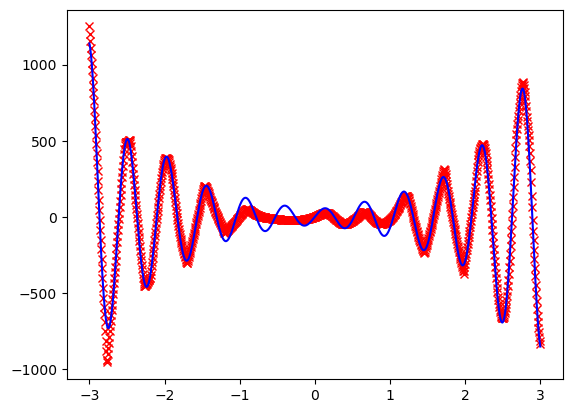

In [12]:
plt.plot(x_test,u_pred,'rx')
plt.plot(x_test,u_true,'b')

In [14]:
a = 0
for i in range(5):
    a = a + test_re_full[i][-1]
print(a/5)

0.1552411036740087
